Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Szymon Budziak"
COLLABORATORS = "None"

---

# Lab 1: Independent Component Analysis

### Machine Learning 2 (2024)

* The grade of the labs will count as bonus. They can boost your final grade up to 1pt before rounding.
* The deadline is Friday, September 20th, 23:59.
* Install the provided assignment to make sure everything runs smoothly.
* Assignment should be submitted through Canvas! Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid1\_lab#", for example, the attached file should be "12345\_lab1.ipynb". 

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
    * For theoretical questions, put your solution using LaTeX style formatting in the YOUR ANSWER HERE cell.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.

In [2]:
import matplotlib
import sys
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
import IPython
# I like to wrap training loops with tqdm, but you don't have to.
from tqdm import tqdm

# Check whether the environment is correct
assert int(sys.version[0]) == 3 and int(sys.version[2]) == 8
assert matplotlib.__version__ == '3.5.2'
assert np.__version__ == '1.22.3'
assert scipy.__version__ == '1.9.0'
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

### Literature
In this assignment, we will implement the Independent Component Analysis algorithm as described in chapter 34 of David MacKay's book "Information Theory, Inference, and Learning Algorithms", which is freely available here:
http://www.inference.phy.cam.ac.uk/mackay/itila/book.html

Read the ICA chapter carefuly before you continue!

### Notation

$\mathbf{X}$ is the $M \times T$ data matrix, containing $M$ measurements at $T$ time steps.

$\mathbf{S}$ is the $S \times T$ source matrix, containing $S$ source signal values at $T$ time steps. We will assume $S = M$.

$\mathbf{A}$ is the mixing matrix. We have $\mathbf{X} = \mathbf{A S}$.

$\mathbf{W}$ is the matrix we aim to learn. It is the inverse of $\mathbf{A}$, up to indeterminacies (scaling and permutation of sources).

$\phi$ is an elementwise non-linearity or activation function, typically applied to elements of $\mathbf{W X}$.

### Code
In the following assignments, you can make use of the signal generators listed below.



In [3]:
# Signal generators
def sawtooth(x, period=0.2, amp=1.0, phase=0.):
    return (((x / period - phase - 0.5) % 1) - 0.5) * 2 * amp


def sine_wave(x, period=0.2, amp=1.0, phase=0.):
    return np.sin((x / period - phase) * 2 * np.pi) * amp


def square_wave(x, period=0.2, amp=1.0, phase=0.):
    return ((np.floor(2 * x / period - 2 * phase - 1) % 2 == 0).astype(float) - 0.5) * 2 * amp


def triangle_wave(x, period=0.2, amp=1.0, phase=0.):
    return (sawtooth(x, period, 1., phase) * square_wave(x, period, 1., phase) + 0.5) * 2 * amp


def random_nonsingular_matrix(d=2):
    """
    Generates a random nonsingular (invertible) matrix of shape d*d
    """
    epsilon = 0.1
    A = np.random.rand(d, d)
    while abs(np.linalg.det(A)) < epsilon:
        A = np.random.rand(d, d)
    return A


def plot_signals(X, title="Signals"):
    """
    Plot the signals contained in the rows of X.
    """
    plt.figure()

    for i in range(X.shape[0]):
        ax = plt.subplot(X.shape[0], 1, i + 1)
        plt.plot(X[i, :])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.suptitle(title)

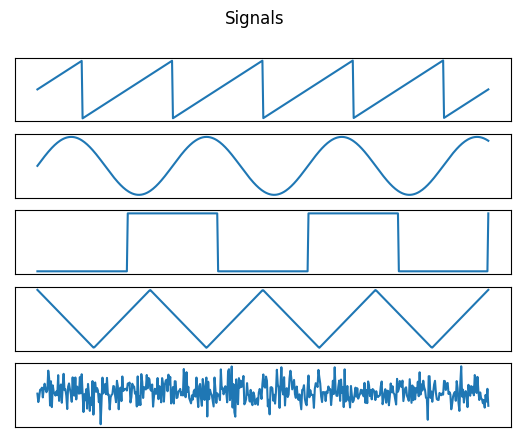

In [4]:
# Let's generate some toy data to work with
num_sources = 5
signal_length = 500
t = np.linspace(0, 1, signal_length)
S = np.c_[sawtooth(t), sine_wave(t, 0.3), square_wave(t, 0.4), triangle_wave(t, 0.25), np.random.randn(t.size)].T
S_names = ["Sawtooth", "Sine", "Square", "Triangle", "Noise"]
plot_signals(S)

### 1.1 Make mixtures (5 points)
Write a function `make_mixtures(S, A)` that takes a matrix of source signals $\mathbf{S}$ and a mixing matrix $\mathbf{A}$, and generates mixed signals $\mathbf{X}$.

In [5]:
### 1.1 Make mixtures
def make_mixtures(S: np.ndarray, A: np.ndarray) -> np.ndarray:
    """
    Mix the source signal S with the mixing matrix A.
    
    Args:
        S (np.ndarray): Source signals
        A (np.ndarray): Mixing matrix

    Returns:
        X (np.ndarray): The mixed signals
    """
    # YOUR CODE HERE
    X = np.dot(A, S)
    return X

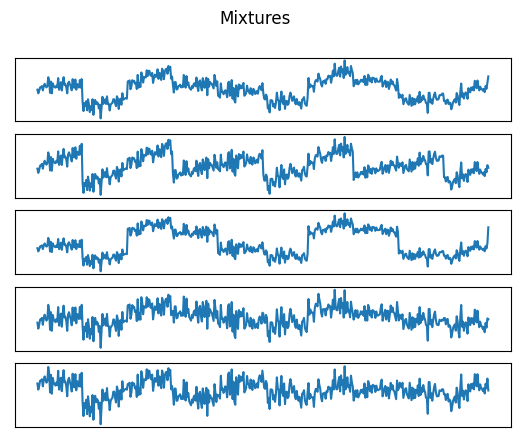

In [6]:
### Test your function
np.random.seed(42)
A = random_nonsingular_matrix(d=S.shape[0])
X = make_mixtures(S, A)
plot_signals(X, "Mixtures")

assert X.shape == (num_sources, signal_length), "The shape of your mixed signals is incorrect"

### 1.2 Histogram
Write a function `plot_histograms(X)` that takes a data-matrix $\mathbf{X}$ and plots one histogram for each signal (row) in $\mathbf{X}$. You can use the `np.histogram()` (followed by `plot`) or `plt.hist()` function. 

Plot histograms of the sources and the measurements.

In [7]:
### 1.2 Histogram
# YOUR CODE HERE
def plot_histograms(X: np.ndarray, names: np.ndarray) -> None:
    """
    Plot the histograms of the signals in X.
    
    Args:
        X (np.ndarray): The signals
        names (np.ndarray): The names of the signals

    Returns:
        None
    """
    fig, ax = plt.subplots(nrows=1, ncols=X.shape[0], figsize=(20, 5))
    for i in range(X.shape[0]):
        data = X[i, :]
        ax[i].hist(data, bins=30)
        ax[i].set_title(names[i])
        ax[i].grid(color='lightgray', linestyle='-', linewidth=0.3, alpha=0.5)

    plt.tight_layout()
    plt.show()

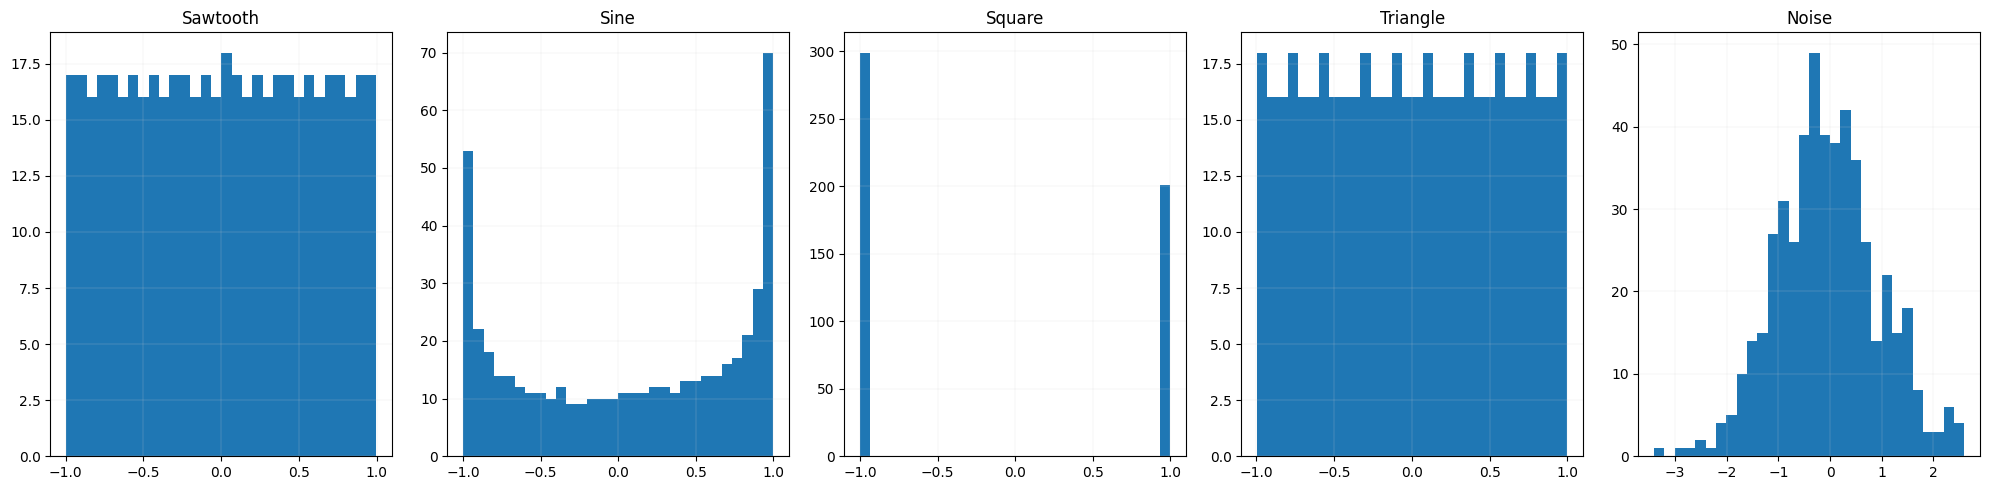

In [8]:
# Plot the histograms of the sources
plot_histograms(S, S_names)

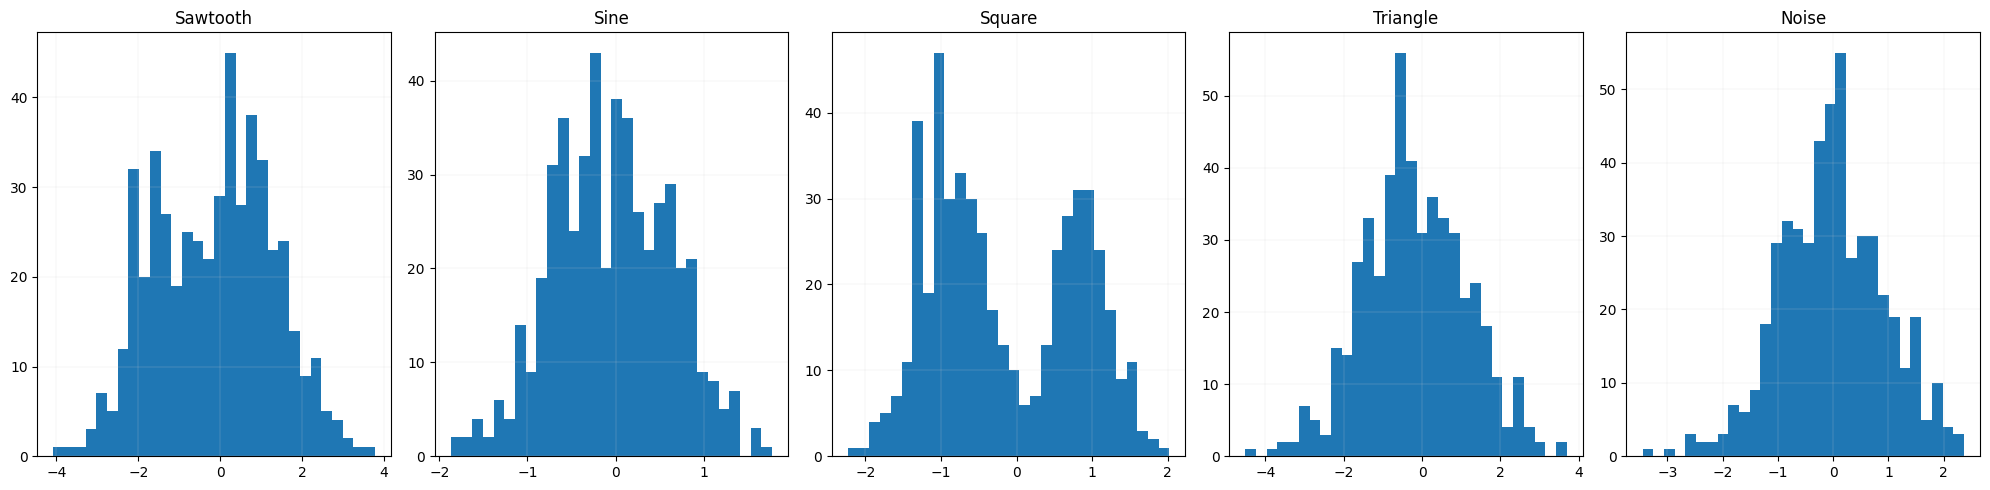

In [9]:
# Plot the histograms of the measurements
plot_histograms(X, S_names)

Which of these distributions (sources or measurements) tend to look more like Gaussians? Can you think of an explanation for this phenomenon? Why is this important for ICA?

## Answer

From the histograms above, we can see that **only last histogram** (Noise) looks `more like Gaussian` than the other signals, since it was generated using `randn` function. However, we can observe that the mixed signals are more Gaussian than the original sources for all the signals.

When independent signals are mixed, their individual characteristics blend resulting mixture that tend to be more Gaussian than the original signals. This is because the `Central Limit Theorem` states that the sum of independent random variables tends to be normally distributed.

Since ICA is a method used to separate a set of mixed signals into their original independent components, it is important that the sources are non-Gaussian and statistically independent (this is one of the key assumptions). ICA relies on the fact that the sources are non-Gaussian, because it is based on the assumption that the sources are statistically independent and non-Gaussian. If the sources are Gaussian, the ICA algorithm will not be able to separate them. $x_i$ will just be weighted sums of the $s_i$:
$$ x_i = a_{i1}s_1 + a_{i2}s_2 + ... + a_{in}s_n$$
the central limit theorem says that the distribution of $x_i$ will be closer to Gaussian than the distribution of $s_i$ itself.

### 1.3 Implicit priors (20 points)
As explained in MacKay's book, an activation function $\phi$ used in the ICA learning algorithm corresponds to a prior distribution over sources. Specifically, $\phi(a) = \frac{d}{da} \ln p(a)$.

For each of the following activation functions, *derive* the source distribution they correspond to.
$$\phi_0(a) = -\tanh(a)$$
$$\phi_1(a) = -a + \tanh(a)$$
$$\phi_2(a) = -a^3$$
$$\phi_3(a) = -\frac{6a}{a^2 + 5}$$

Give your answer without the normalizing constant, so an answer of the form $p(a) \propto \verb + [answer] +$ is ok.

## Answer

1) **Activation function $\phi_0(a) = -\tanh(a)$**:

We can derive the source distribution $p_0(a)$ by integrating $\phi_0(a)$:

$$
\int - \tan(a)da = - \ln(\cosh(a)) + C
$$

Exponentiating both sides, give us:

$$
p_0(a) \propto \exp(- \ln(\cosh(a))) = \frac{1}{\cosh(a)}
$$

2) **Activation function $\phi_1(a) = -a + \tanh(a)$**:

We can derive the source distribution $p_1(a)$ by integrating $\phi_1(a)$. We can split the function into two parts and integrate them separately:

$$
\int (-a + \tanh(a)) da =  \int -ada + \int \tanh(a)da = -0.5a^2 + \ln(\cosh(a)) + C
$$

Exponentiating both sides, give us:

$$
p_1(a) \propto \exp(-0.5a^2 + \ln(\cosh(a))) = \frac{\cosh(a)}{exp({a^2/2})}
$$

3) **Activation function $\phi_2(a) = -a^3$**:

We can derive the source distribution $p_2(a)$ by integrating $\phi_2(a)$:

$$
\int -a^3da = -\frac{1}{4}a^4 + C
$$

Exponentiating both sides, give us:

$$
p_2(a) \propto \exp(-\frac{1}{4}a^4)
$$


4) **Activation function $\phi_3(a) = -\frac{6a}{a^2 + 5}$**:

We can derive the source distribution $p_3(a)$ by integrating $\phi_3(a)$. To solve this integral, we can use a substitution:

$$
u = a^2 + 5
$$
$$
du = 2ada
$$

$$
\int -\frac{6a}{a^2 + 5}da = -3\ln(a^2 + 5) + C
$$

Exponentiating both sides, give us:

$$
p_3(a) \propto \exp(-3\ln(a^2 + 5)) = \frac{1}{(a^2 + 5)^3}
$$

In [10]:
def phi_0(a):
    return -np.tanh(a)


def p_0(a: np.ndarray) -> np.ndarray:
    # YOUR CODE HERE
    return 1 / np.cosh(a)

In [11]:
def phi_1(a):
    return -a + np.tanh(a)


def p_1(a: np.ndarray) -> np.ndarray:
    # YOUR CODE HERE
    return np.cosh(a) / np.exp(a ** 2 / 2)

In [12]:
def phi_2(a):
    return -a ** 3


def p_2(a: np.ndarray) -> np.ndarray:
    # YOUR CODE HERE
    return np.exp(-0.25 * a ** 4)

In [13]:
def phi_3(a):
    return -6 * a / (a ** 2 + 5)


def p_3(a: np.ndarray) -> np.ndarray:
    # YOUR CODE HERE
    return 1 / (a ** 2 + 5) ** 3

In [14]:
activation_functions = [phi_0, phi_1, phi_2, phi_3]
priors = [p_0, p_1, p_2, p_3]

a = np.linspace(-5, 5, 1000)
for prior in priors:
    assert prior(a).shape == (1000,), "Wrong output shape"

# The cells below contain tests for each activation, don't mind them!

Plot the activation functions and the corresponding prior distributions, from $a = -5$ to $5$ (hint: use the lists defined in the cell above). Compare the shape of the priors to the histogram you plotted in the last question.

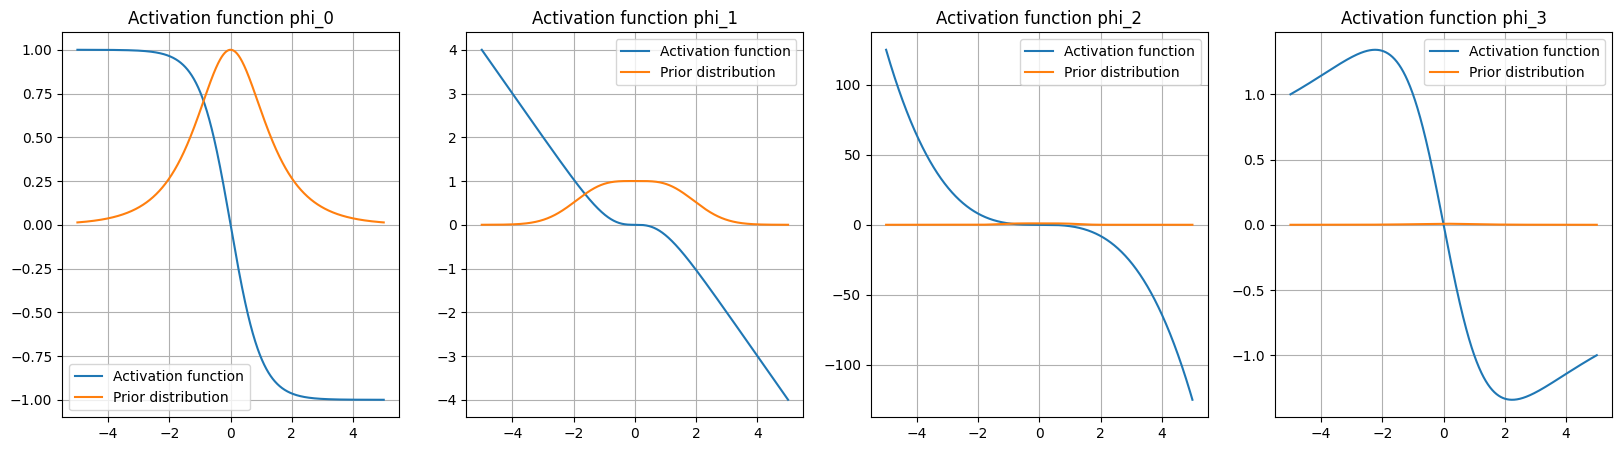

In [15]:
### 1.3 Implicit priors (continued)
a = np.linspace(-5, 5, 1000)


# YOUR CODE HERE
def plot_activation_functions(a: np.ndarray, activation_functions: list, priors: list) -> None:
    """
    Plot the activation functions and the corresponding prior distributions.
    
    Args:
        a (np.ndarray): The input data 
        activation_functions (list): The list of activation functions
        priors (list): The list of prior distributions

    Returns:
        None
    """
    fig, ax = plt.subplots(nrows=1, ncols=len(activation_functions), figsize=(20, 5))

    for i, (prior, phi) in enumerate(zip(priors, activation_functions)):
        ax[i].plot(a, phi(a), label='Activation function')
        ax[i].plot(a, prior(a), label='Prior distribution')
        ax[i].set_title(f'Activation function {phi.__name__}')
        ax[i].legend()
        ax[i].grid()

    plt.show()


plot_activation_functions(a, activation_functions, priors)

### 1.4 Whitening (15 points)
Some ICA algorithms can only learn from whitened data. Write a method `whiten(X)` that takes a $M \times T$ data matrix $\mathbf{X}$ (where $M$ is the dimensionality and $T$ the number of examples) and returns a whitened matrix. If you forgot what whitening is or how to compute it, various good sources are available online, such as http://courses.media.mit.edu/2010fall/mas622j/whiten.pdf. Your function should also center the data before whitening.

In [16]:
### 1.4 Whitening
def whiten(X: np.ndarray) -> np.ndarray:
    """
    Whitens the input matrix X.
    Implementation based on: https://courses.media.mit.edu/2010fall/mas622j/whiten.pdf
    
    Args:
        X (np.ndarray): The input data matrix 

    Returns:
        np.ndarray: The whitened matrix
    """
    # YOUR CODE HERE
    X_centered = X - np.mean(X, axis=1, keepdims=True)  # Center the data before whitening
    cov = np.cov(X_centered)  # Compute the covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov)  # Perform eigenvalue decomposition
    X_decorrelated = eigvecs.T @ X_centered  # Decorrelate: Multiply by eigenvectors
    X_whitened = X_decorrelated / np.sqrt(eigvals[:, np.newaxis])
    # Normalize the variance by dividing by the square root of eigenvalues    
    return X_whitened

In [17]:
### Test your function
Xw = whiten(X)
assert Xw.shape == (num_sources, signal_length), "The shape of your mixed signals is incorrect"

### 1.5 Interpret results of whitening 
Make 3 figures, one for the sources, one for measurements and one for the whitened measurements. In each figure, make $5 \times 5$ subplots with scatter plots for each pair of signals. Each axis represents a signal and each time-instance is plotted as a dot in this space. You can use the `plt.scatter()` function.

Now compute and visualize the covariance matrix of the sources, the measurements and the whitened measurements. You can visualize each covariance matrix using this code:
```python
# Dummy covariance matrix C;
C = np.eye(5)  
ax = imshow(C, cmap='gray', interpolation='nearest')
```

In [18]:
### 1.5 Interpret results of whitening
# YOUR CODE HERE
def plot_scatter(X: np.ndarray, title: str, color: str = 'blue') -> None:
    """
    Plot the scatter plots for the input data matrix X.
    
    Args:
        X (np.ndarray): The input data matrix 
        title (str): The title of the plot
        color (str): The color of the scatter plot

    Returns:
        None
    """
    signals_num = X.shape[0]
    fig, ax = plt.subplots(signals_num, signals_num, figsize=(15, 15))

    for i in range(signals_num):
        for j in range(signals_num):
            ax[i, j].scatter(X[i, :], X[j, :], s=3, color=color)
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            if i == 0:
                ax[i, j].set_title(f'Signal {j}')
            if j == 0:
                ax[i, j].set_ylabel(f'Signal {i}')

            ax[i, j].grid(color='lightgray', linestyle='-', linewidth=0.3)
            plt.tight_layout()

    fig.suptitle(title, fontsize=24)
    plt.show()

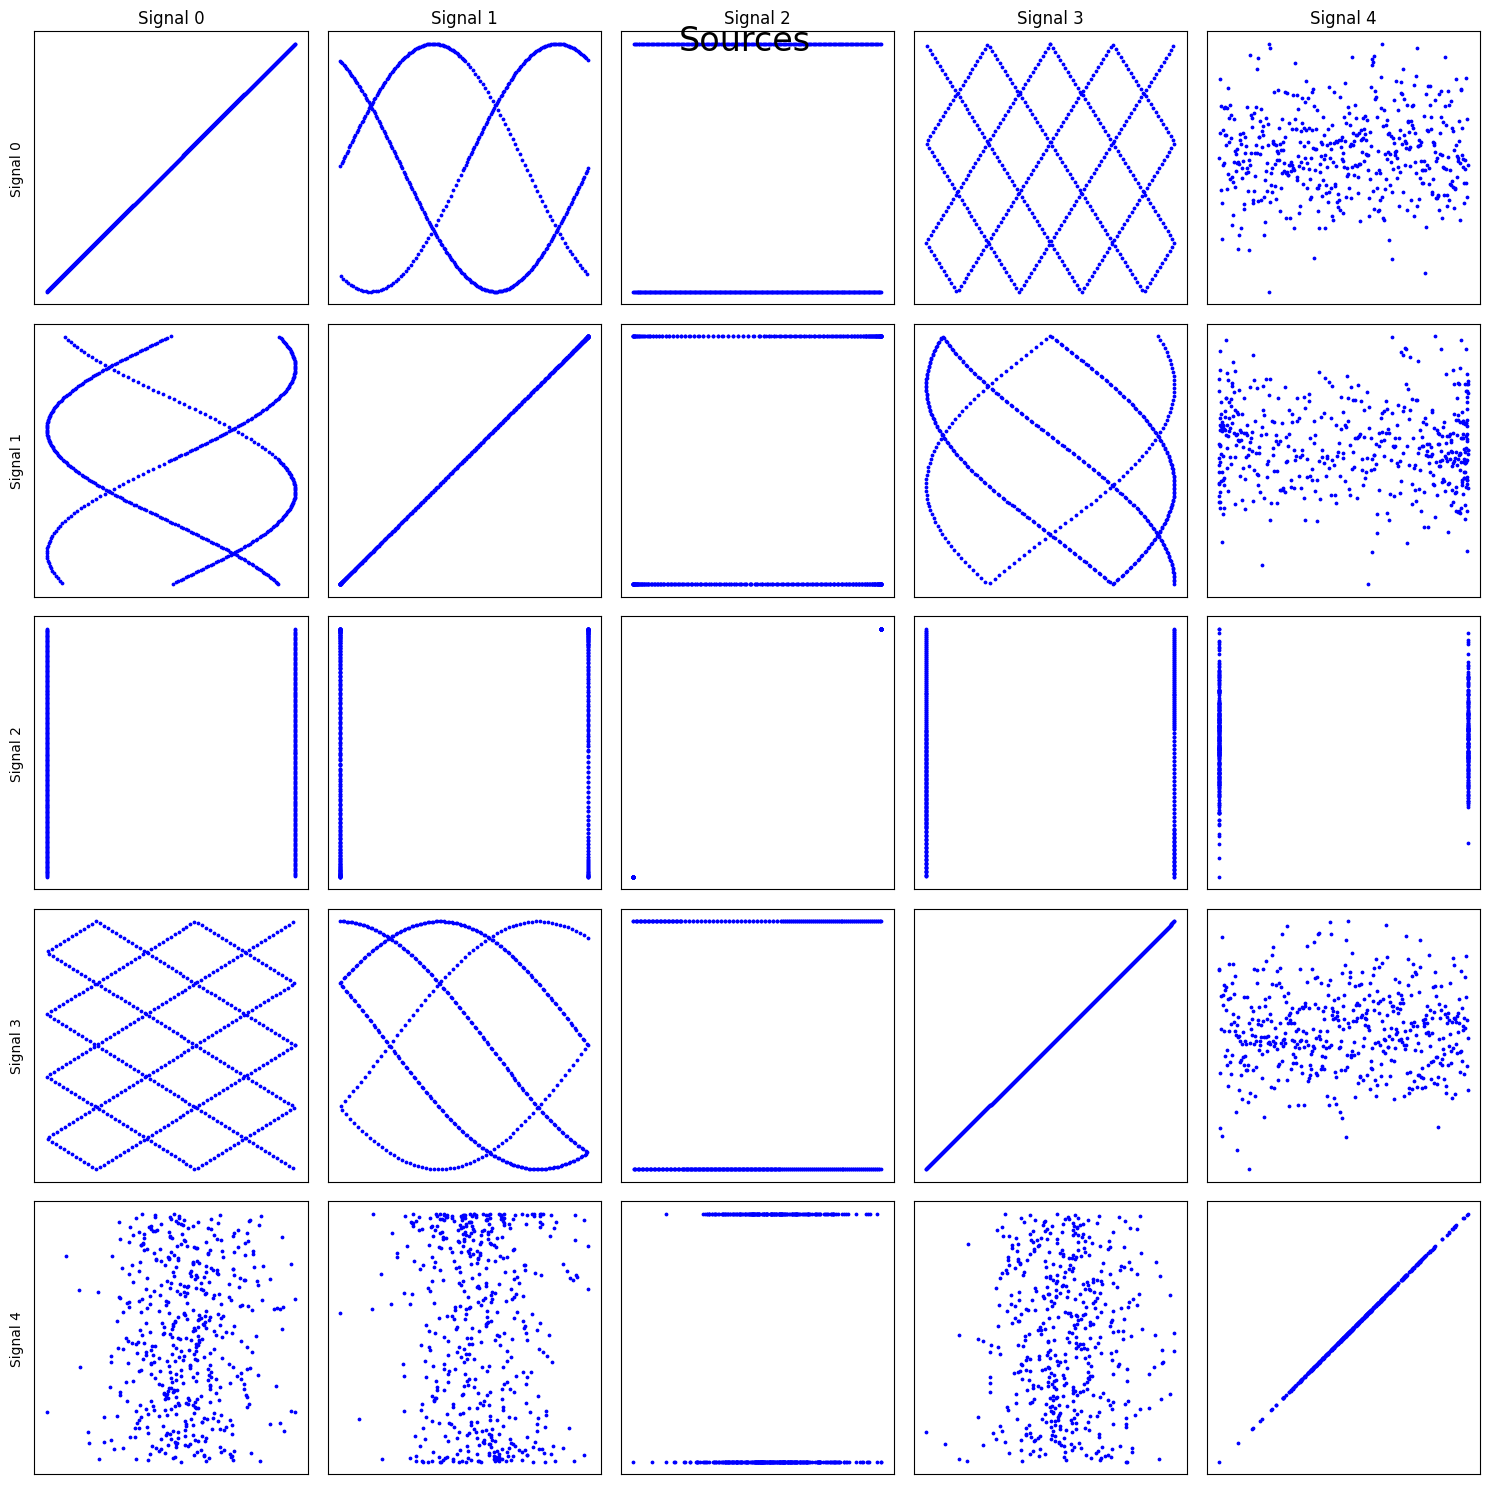

In [19]:
# Plot scatter plots for the sources
plot_scatter(S, 'Sources')

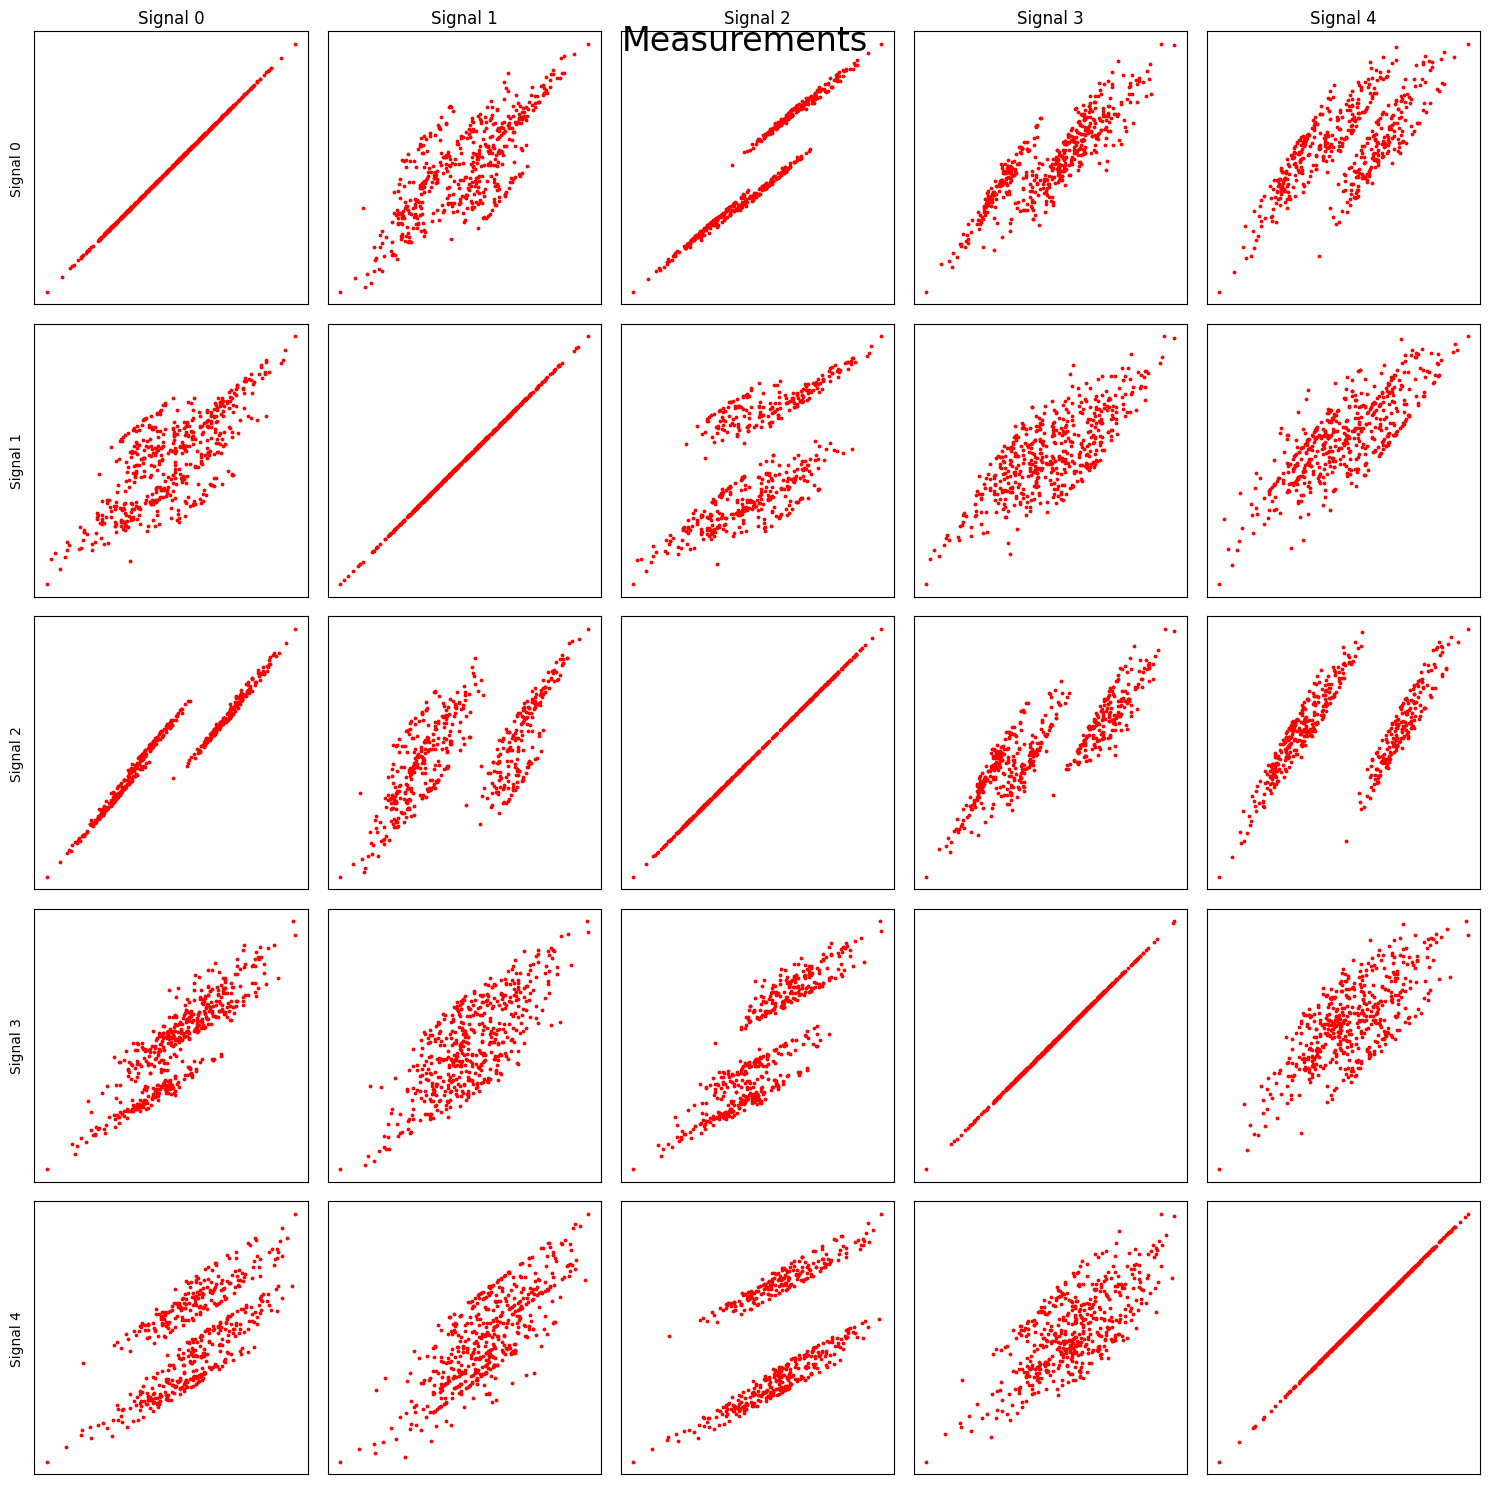

In [20]:
# Plot scatter plots for the measurements
plot_scatter(X, 'Measurements', color='red')

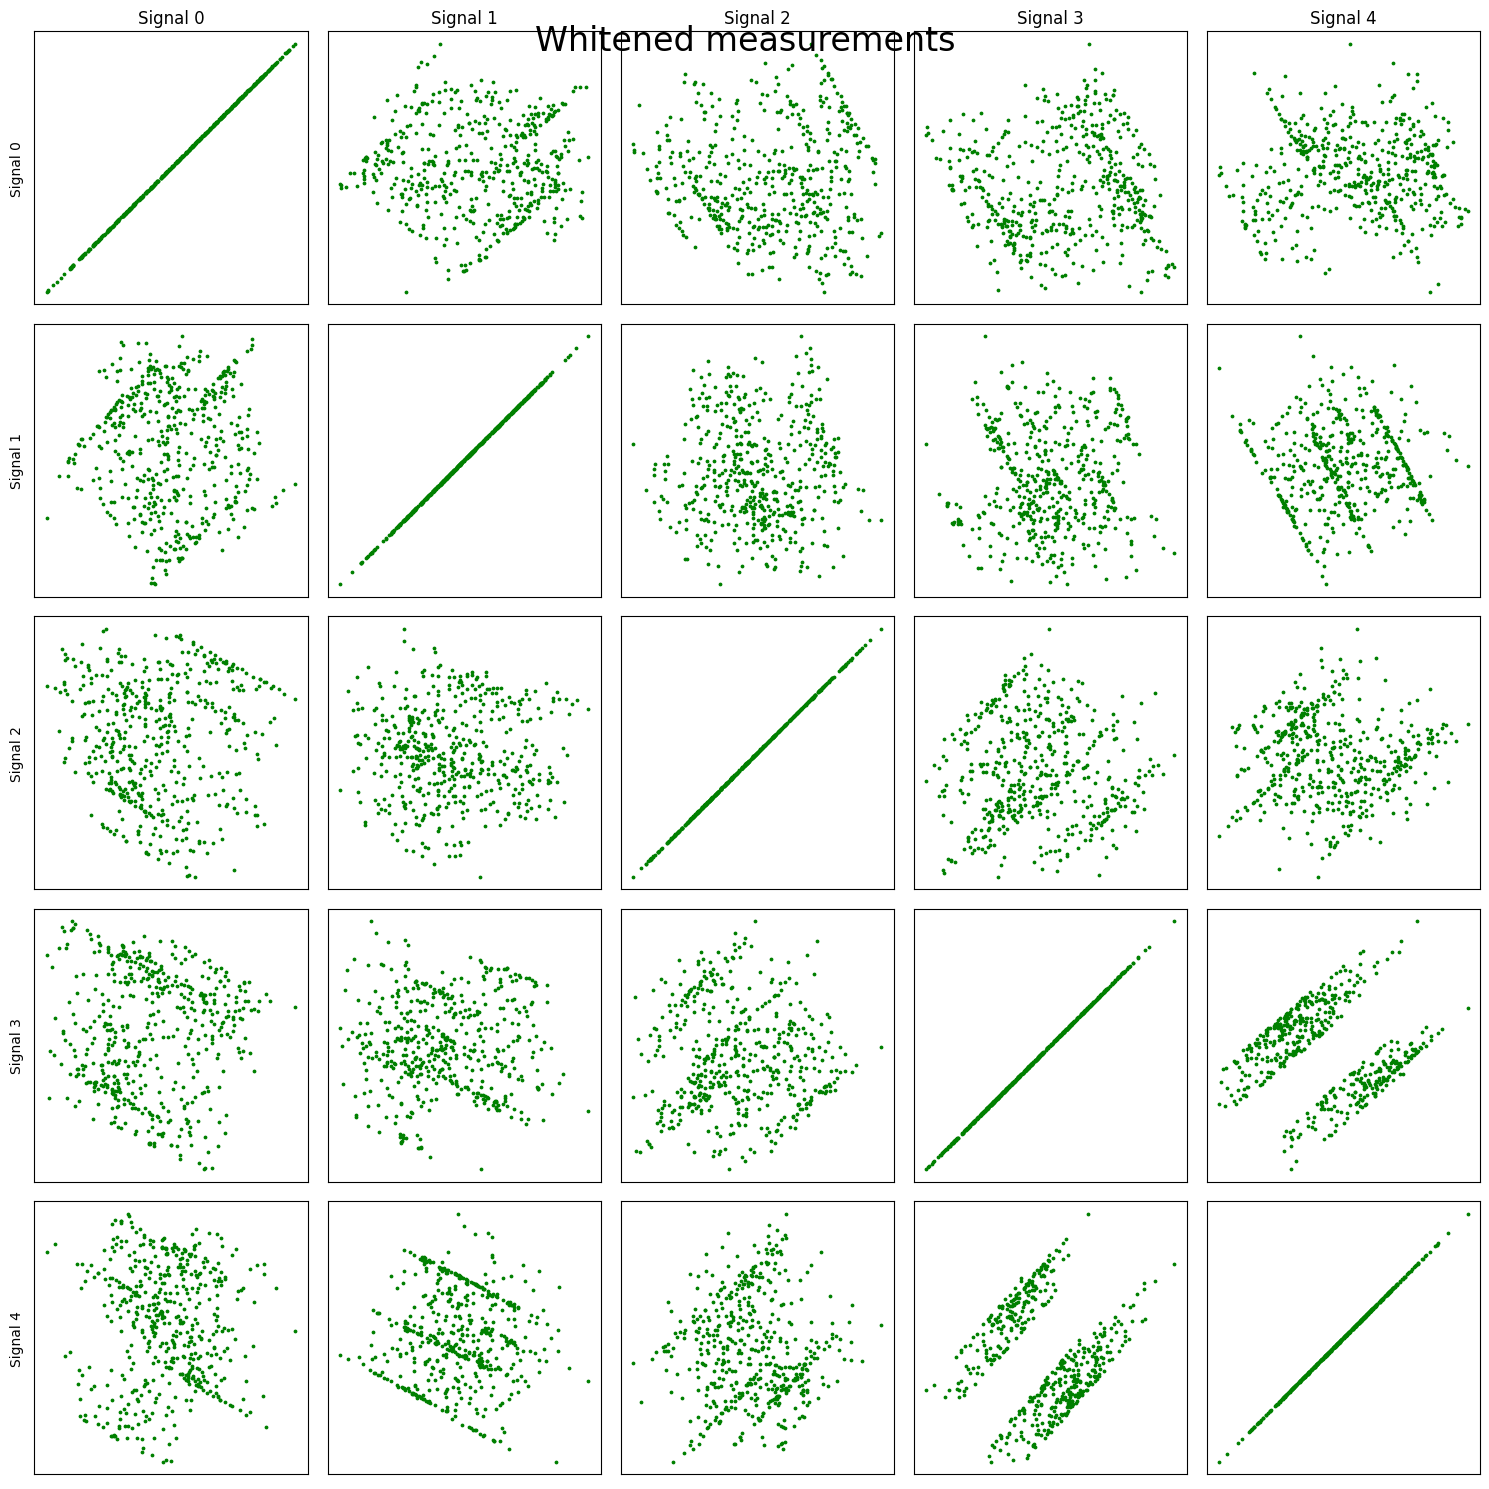

In [21]:
# Plot scatter plots for the whitened measurements
plot_scatter(Xw, 'Whitened measurements', color='green')

In [22]:
def plot_covariance_matrix(cov_data: list, names: list) -> None:
    """
    Plot the covariance matrices of the input data that contains the covariance matrices of the sources, measurements, and whitened measurements.
    
    Args:
        cov_data (list): The list of covariance matrices 
        names (list): The names of the covariance matrices

    Returns:
        None
    """
    fig, ax = plt.subplots(nrows=1, ncols=len(cov_data), figsize=(8, 8))
    for i in range(len(cov_data)):
        cov_matrix = np.cov(cov_data[i])
        ax[i].imshow(cov_matrix, cmap='gray', interpolation='nearest')
        ax[i].set_title(names[i])
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        plt.tight_layout()

    cbar = plt.colorbar(ax[-1].imshow(cov_matrix, cmap='gray', interpolation='nearest'), ax=ax, orientation='vertical')
    cbar.set_label('Covariance')
    fig.suptitle('Covariance matrices', fontsize=20)
    plt.show()

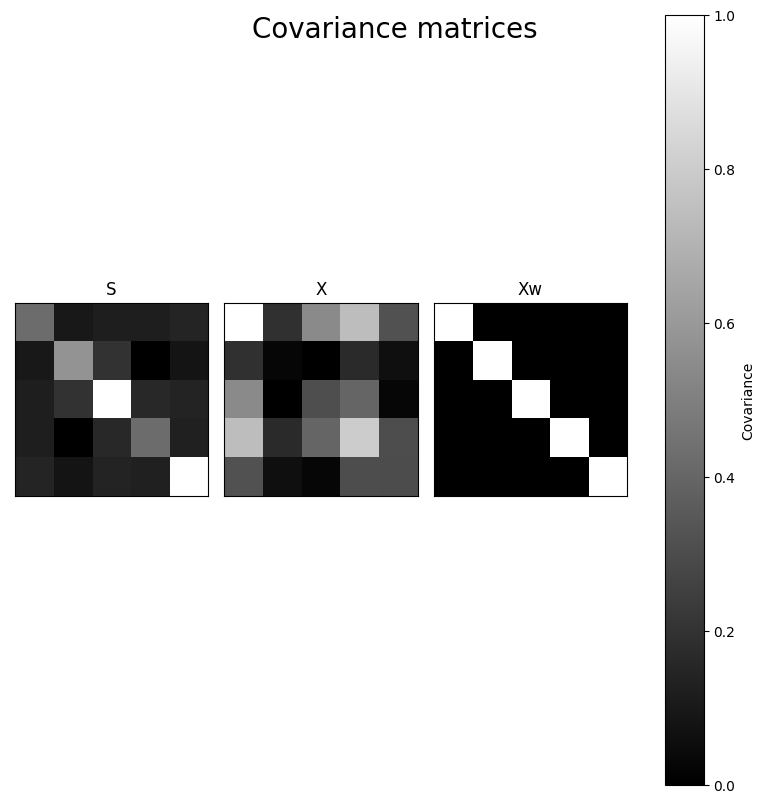

In [23]:
# Plot the covariance matrix of the sources
plot_covariance_matrix([S, X, Xw], names=['S', 'X', 'Xw'])

## Answer

### Scatter Plots interpretation
- **Sources**: The scatter plots of the sources show that the signals are not independent, as the scatter plots are not spherical. The scatter plots show that the signals are minimal correlated, which is expected as the sources are generated using different functions. However there is no obvious pattern in those plots.
- **Measurements**: The scatter plots of the measurements show that the signals are correlated, as the scatter plots are not spherical. This is expected as the signals are mixed together. We can observe more structured patterns.
- **Whitened Measurements**: The scatter plots of the whitened measurements show that the signals are independent, as the scatter plots are random, spherical. This is expected as the whitening removes the correlations between the signals.

### Covariance Matrices interpretation
The covariance matrix is a square matrix that contains the variances of the signals on the diagonal and the covariances between the signals off the diagonal. The covariance matrix is a measure of how much two signals change together. If the covariance is positive, the signals change together in the same direction, if it is negative, they change in opposite directions, and if it is zero, they are independent.

- **Sources (S)**: The covariance matrix of the independent sources is nearly diagonal with minimal off-diagonal values, which means that the signals are independent. This is expected as the sources are generated using different functions. Values off-diagonal are close to zero, which means that the signals are uncorrelated.
- **Measurements (X)**: The covariance matrix of the measurements is not diagonal, which means that the signals are correlated. This is expected as the signals are mixed together.
- **Whitened Measurements (Xw)**: The covariance matrix of the whitened measurements is identity matrix, which means that the signals are now independent. This is because whitening removes the correlations between the signals, making them independent. The data is rescaled such that all the new features have unit variance. The scatter plots of whitened measurements show uncorrelated data, resulting in more spherical scatter plots.

### 1.6 Independent Component Analysis (24 points)
Implement the covariant ICA algorithm as described in MacKay. Write a function `ICA(X, activation_function, learning_rate)`, that returns the demixing matrix $\mathbf{W}$. The input `activation_function` should accept a function such as `lambda a: -tanh(a)`. Update the gradient in batch mode, averaging the gradients over the whole dataset for each update. Make it efficient, so use matrix operations instead of loops where possible (loops are slow in interpreted languages such as python and matlab, whereas matrix operations are internally computed using fast C code). Experiment with the learning rate and the initialization of $\mathbf{W}$. Your algorithm should be able to converge (i.e. `np.linalg.norm(grad) < 1e-5`) in within 10000 steps.

In [24]:
### 1.7 Independent Component Analysis
def xavier_initialization(M: int):
    limit = np.sqrt(2 / (M + M))
    return np.random.uniform(-limit, limit, (M, M))


def ICA(X: np.ndarray, activation_function, learning_rate: float = 0.1, max_steps: int = 10000,
        w_init_name: str = 'eye', tolerance: float = 1e-5, return_steps: bool = False):
    """
    Perform Independent Component Analysis on the data X.
    
    Args:
        X (np.ndarray): The input data matrix 
        activation_function: The activation function
        learning_rate (float): The step size for gradient updates
        max_steps (int): Maximum number of iterations to perform
        w_init_name (str): The initialization method for the demixing matrix
        tolerance: float: The tolerance for the gradient norm to determine convergence
        return_steps (bool): Whether to return the number of steps taken

    Returns:
        W (np.ndarray): The demixing matrix (M x M) that, when multiplied by X, recovers the independent sources
        total_steps (int): The total number of steps taken
    """
    # YOUR CODE HERE
    M, T = X.shape

    if w_init_name == 'eye':
        W = np.eye(M)  # Initialize the weights with Identity matrix
    elif w_init_name == 'orthogonal':
        W, _ = np.linalg.qr(np.random.randn(M, M))  # Initialize the weights with orthogonal matrix
    elif w_init_name == 'xavier':
        W = xavier_initialization(M)  # Initialize the weights using Glorot (Xavier) initialization
    elif w_init_name == 'nonsingular':
        W = random_nonsingular_matrix(
            d=M)  # Initialize the weights with random nonsingular matrix (random normal values)
    else:
        W = np.eye(M)

    W *= 0.1  # Scale the weights to reduce variance and fight overfitting
    total_steps = 0

    # Perform the gradient updates
    for step in range(max_steps):
        a = W @ X  # Put X through the demixing matrix
        z = activation_function(a)  # Apply the activation function
        X_prime = W.T @ a  # Compute the reconstructed signals
        grad = W + (z @ X_prime.T) / T  # Compute the gradient for W and averages the gradient over add data points
        W += learning_rate * grad  # Update W

        grad_norm = np.linalg.norm(grad)
        if np.isnan(grad_norm) or np.isinf(grad_norm):
            print('Warning! Overflow encountered. DID NOT converge!')
            break

        if grad_norm < tolerance:
            print(f"Successfully converged after {step} steps!")
            break

        total_steps += 1

    else:
        print(f"DID NOT converged within {max_steps} steps!")

    if return_steps:
        return W, total_steps
    else:
        return W


W_est = ICA(Xw, phi_3)  # Compare with ICA(X)

Successfully converged after 2182 steps!


In [25]:
# We will test your function so make sure it runs with only X and phi as input, and returns only W
# Also it should converge for all activation functions

W_estimates = [ICA(Xw, activation_function=phi) for phi in activation_functions]
assert all([W_est.shape == (num_sources, num_sources) for W_est in W_estimates])
# Again, the cells below contain hidden tests, don't mind them!

Successfully converged after 1847 steps!
Successfully converged after 1483 steps!
Successfully converged after 1201 steps!
Successfully converged after 2182 steps!


## Experimenting with different weight initializations

- **Random normal initialization**: While initializing just with the np.random.randn(M, M) I encountered overflow for phi_2. Which means that the W values are too large and the activation function is not able to handle them.
- **Random rand initialization with smaller values**: W initialization with `W = np.random.randn(M, M) * 0.01` solves the problem of overflow. When it comes to convergence all activation functions converged.
- **Identity Matrix Initialization**: Initializing W as an identity matrix using `W = np.eye(M) * 0.1` also solves the problem of overflow. When it comes to convergence all activation functions converged.
- **Orthogonal Initialization**: Initializing W as an orthogonal matrix using `W, _ = np.linalg.qr(np.random.randn(M, M))` also solves the problem of overflow. When it comes to convergence all activation functions converged.
- **Glorot (Xavier) Initialization**: Initializing W using Glorot (Xavier) initialization solves the problem of overflow. When it comes to convergence all activation functions converged. his method initializes weights to be scaled based on the size of the input and output layers. It's a compromise between large and small initializations and helps maintain the signal through the network.

Out of all tested W initializations the best choice seems to be the `Identity Matrix initialization` as it converges for all activation functions the fastest. An alternative coule be an `Orthogonal Initialization` as it also converges for all activation functions and is also fast.

### 1.8 Experiments  (5 points)
Run ICA on the provided signals using each activation function $\phi_0, \ldots, \phi_3$. Use the found demixing matrix $\mathbf{W}$ to reconstruct the signals and plot the retreived signals for each choice of activation function.

In [26]:
# 1.8 Experiments
# YOUR CODE HERE
def plot_reconstructed_signals(X_whit: np.ndarray, W_estimates: list) -> None:
    """
    Plot the reconstructed signals using the estimated demixing matrices.
    
    Args:
        X_whit (np.ndarray): The whitened data matrix 
        W_estimates (list): The list of estimated demixing matrices

    Returns:
        None
    """
    fig, ax = plt.subplots(nrows=len(W_estimates), ncols=X_whit.shape[0], figsize=(20, 15))
    titles = ['phi_0', 'phi_1', 'phi_2', 'phi_3']
    colors = ['blue', 'red', 'green', 'orange']

    for i, W in enumerate(W_estimates):
        # Reconstruct the signals
        X_reconstructed = W @ X_whit

        # Plot the reconstructed signals
        for j in range(X_reconstructed.shape[0]):
            ax[i, j].plot(X_reconstructed[j], color=colors[i])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].set_title(f"{titles[i]} - Signal {j + 1}")
            ax[i, j].grid(color='lightgray', linestyle='-', linewidth=0.3)
            plt.tight_layout()

    plt.show()

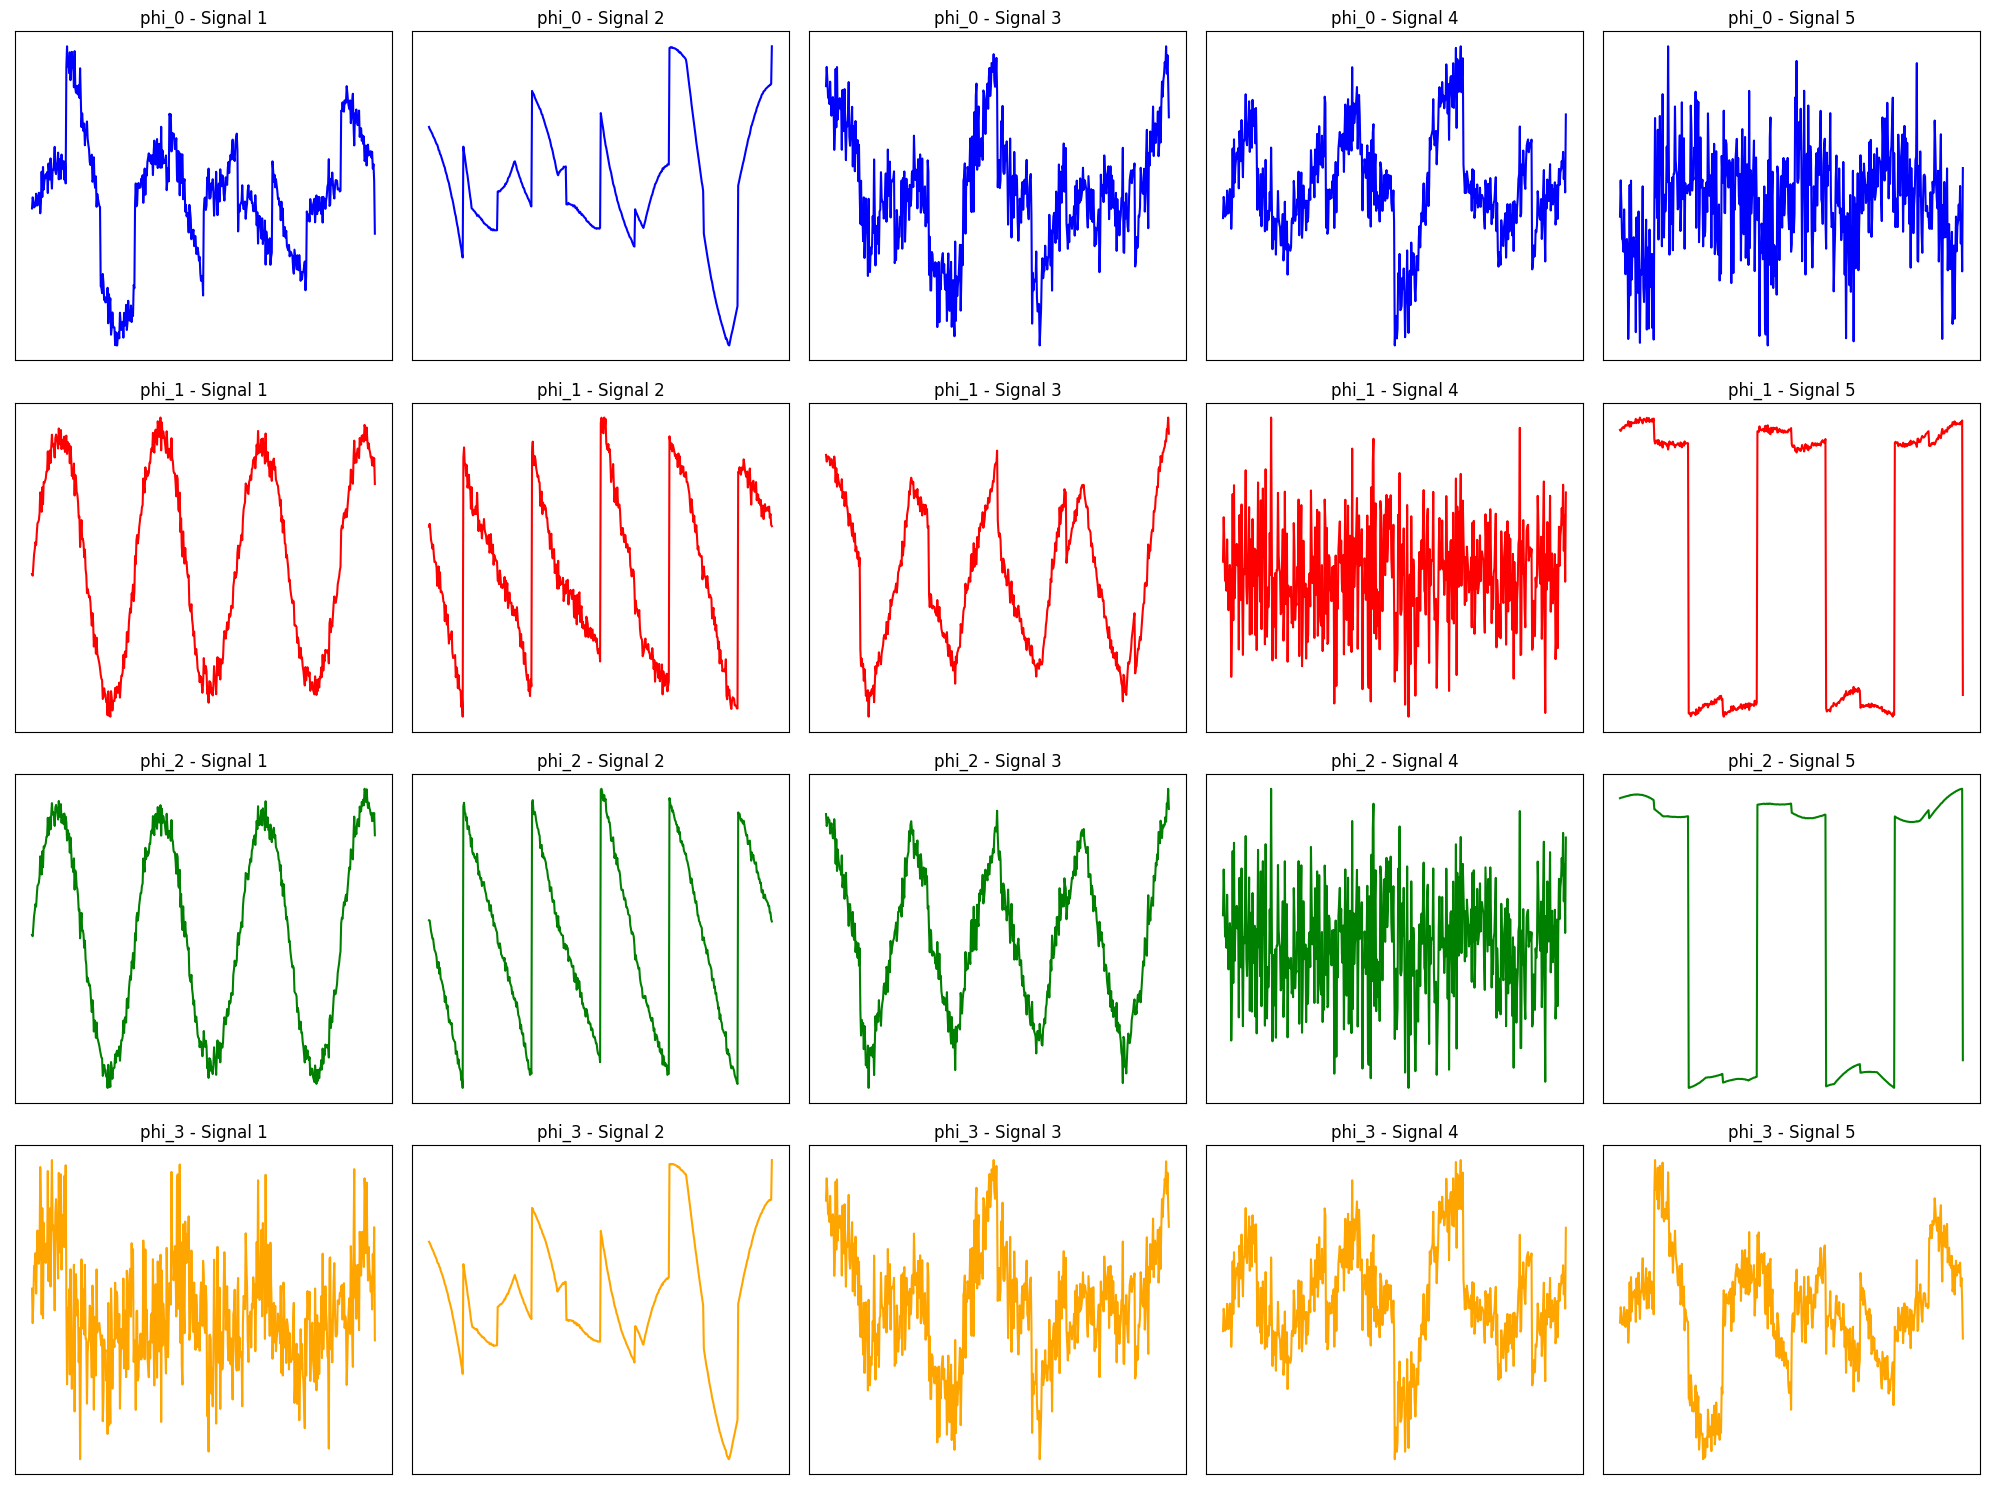

In [27]:
plot_reconstructed_signals(Xw, W_estimates)

In [28]:
def does_whitening_make_a_difference(phi=activation_functions[1]):
    """
    Check if whitening the data makes a difference in the speed of convergence of the ICA algorithm
    
    Args:
        phi (function): The activation function 

    Returns:
        bool: True if whitening the data makes a difference in the speed of convergence of the ICA algorithm
    """
    # Does it make a difference (in terms of speed of convergence) if you whiten your data before running ICA?
    # Return True or False
    # YOUR CODE HERE

    _, white_steps = ICA(Xw, phi, return_steps=True)

    _, no_whiten_steps = ICA(X, phi, return_steps=True)

    # Check if the whitened data converges faster than the non-whitened data
    return white_steps < no_whiten_steps

In [29]:
assert type(does_whitening_make_a_difference()) == bool

Successfully converged after 1483 steps!
Successfully converged after 1530 steps!


In [30]:
print(does_whitening_make_a_difference())

Successfully converged after 1483 steps!
Successfully converged after 1530 steps!
True


### 1.9 Audio demixing (10 points)
The 'cocktail party effect' refers to the ability humans have to attend to one speaker in a noisy room. We will now use ICA to solve a similar but somewhat idealized version of this problem. The code below loads 5 sound files and plots them.

Use a random non-singular mixing matrix to mix the 5 sound files. You can listen to the results in your browser using `play_signals`, or save them to disk if this does not work for you. Plot histograms of the mixed audio and use your ICA implementation to de-mix these and reproduce the original source signals. As in the previous exercise, try each of the activation functions.

Keep in mind that this problem is easier than the real cocktail party problem, because in real life there are often more sources than measurements (we have only two ears!), and the number of sources is unknown and variable. Also, mixing is not instantaneous in real life, because the sound from one source arrives at each ear at a different point in time. If you have time left, you can think of ways to deal with these issues.

In [31]:
import scipy.io.wavfile
from IPython.display import Audio, display, Markdown


# Save mixtures to disk, so you can listen to them in your audio player
def save_wav(data, out_file, rate):
    scaled = np.int16(data / np.max(np.abs(data)) * 32767)
    scipy.io.wavfile.write(out_file, rate, scaled)


# Or play them in your browser
def play_signals(S, sample_rate, title="Signals"):
    display(Markdown(title))
    for signal in S:
        display(Audio(signal, rate=sample_rate))

Signals

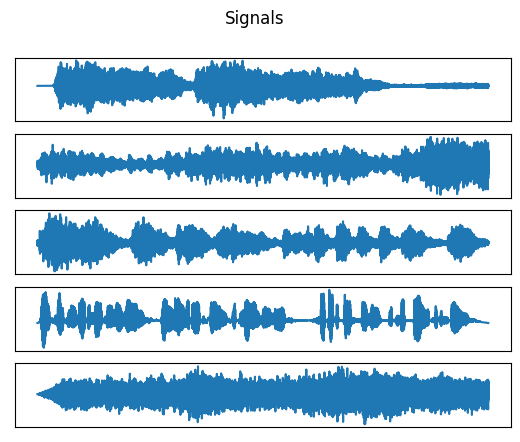

In [32]:
# Load audio sources
# source_files = ['beet.wav', 'beet9.wav', 'beet92.wav', 'mike.wav', 'street.wav']
source_files = ['data/beet.wav', 'data/beet9.wav', 'data/beet92.wav', 'data/mike.wav', 'data/street.wav']
wav_data = []
sample_rate = None
for f in source_files:
    sr, data = scipy.io.wavfile.read(f, mmap=False)
    if sample_rate is None:
        sample_rate = sr
    else:
        assert (sample_rate == sr)
    wav_data.append(data[:190000])  # cut off the last part so that all signals have same length
# Create source and measurement data
S_audio = np.c_[wav_data]
plot_signals(S_audio)
play_signals(S_audio, sample_rate)

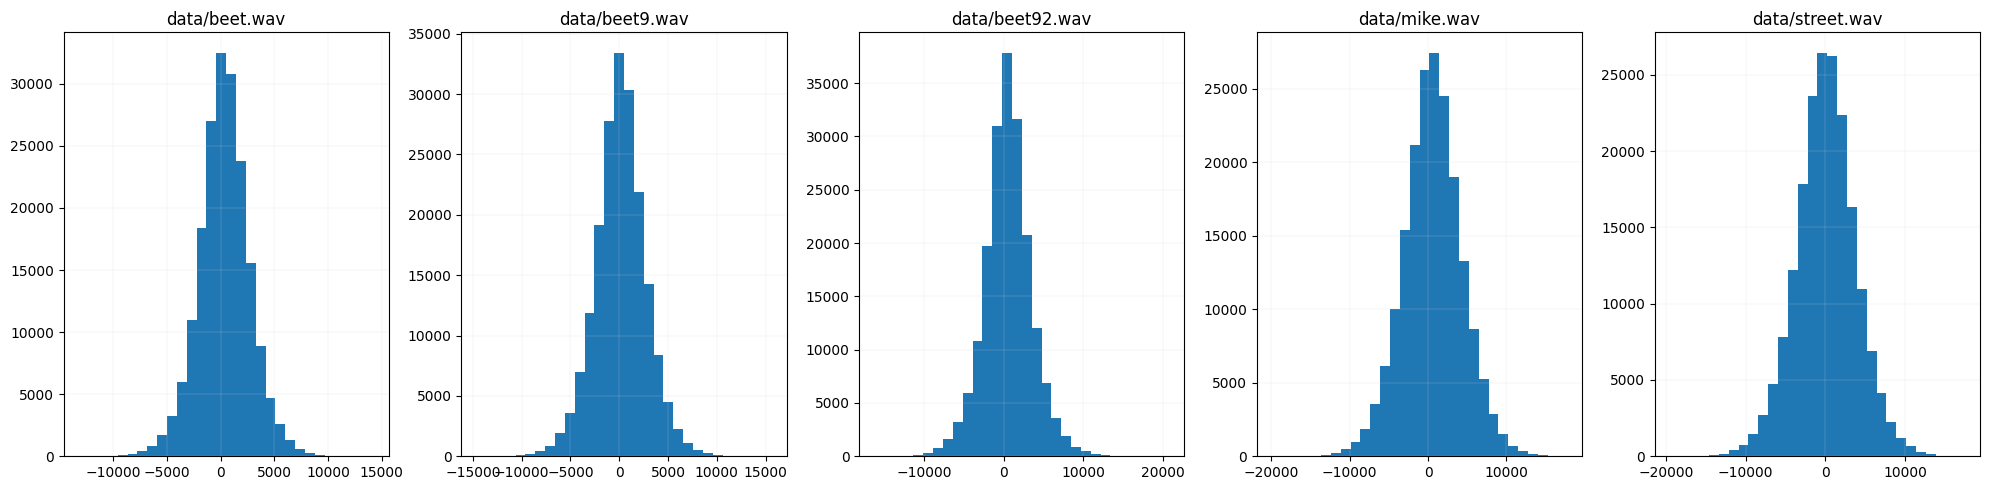

Successfully converged after 580 steps!
Successfully converged after 9536 steps!
Successfully converged after 3635 steps!
Successfully converged after 628 steps!
Reconstructed signals using eye initialization


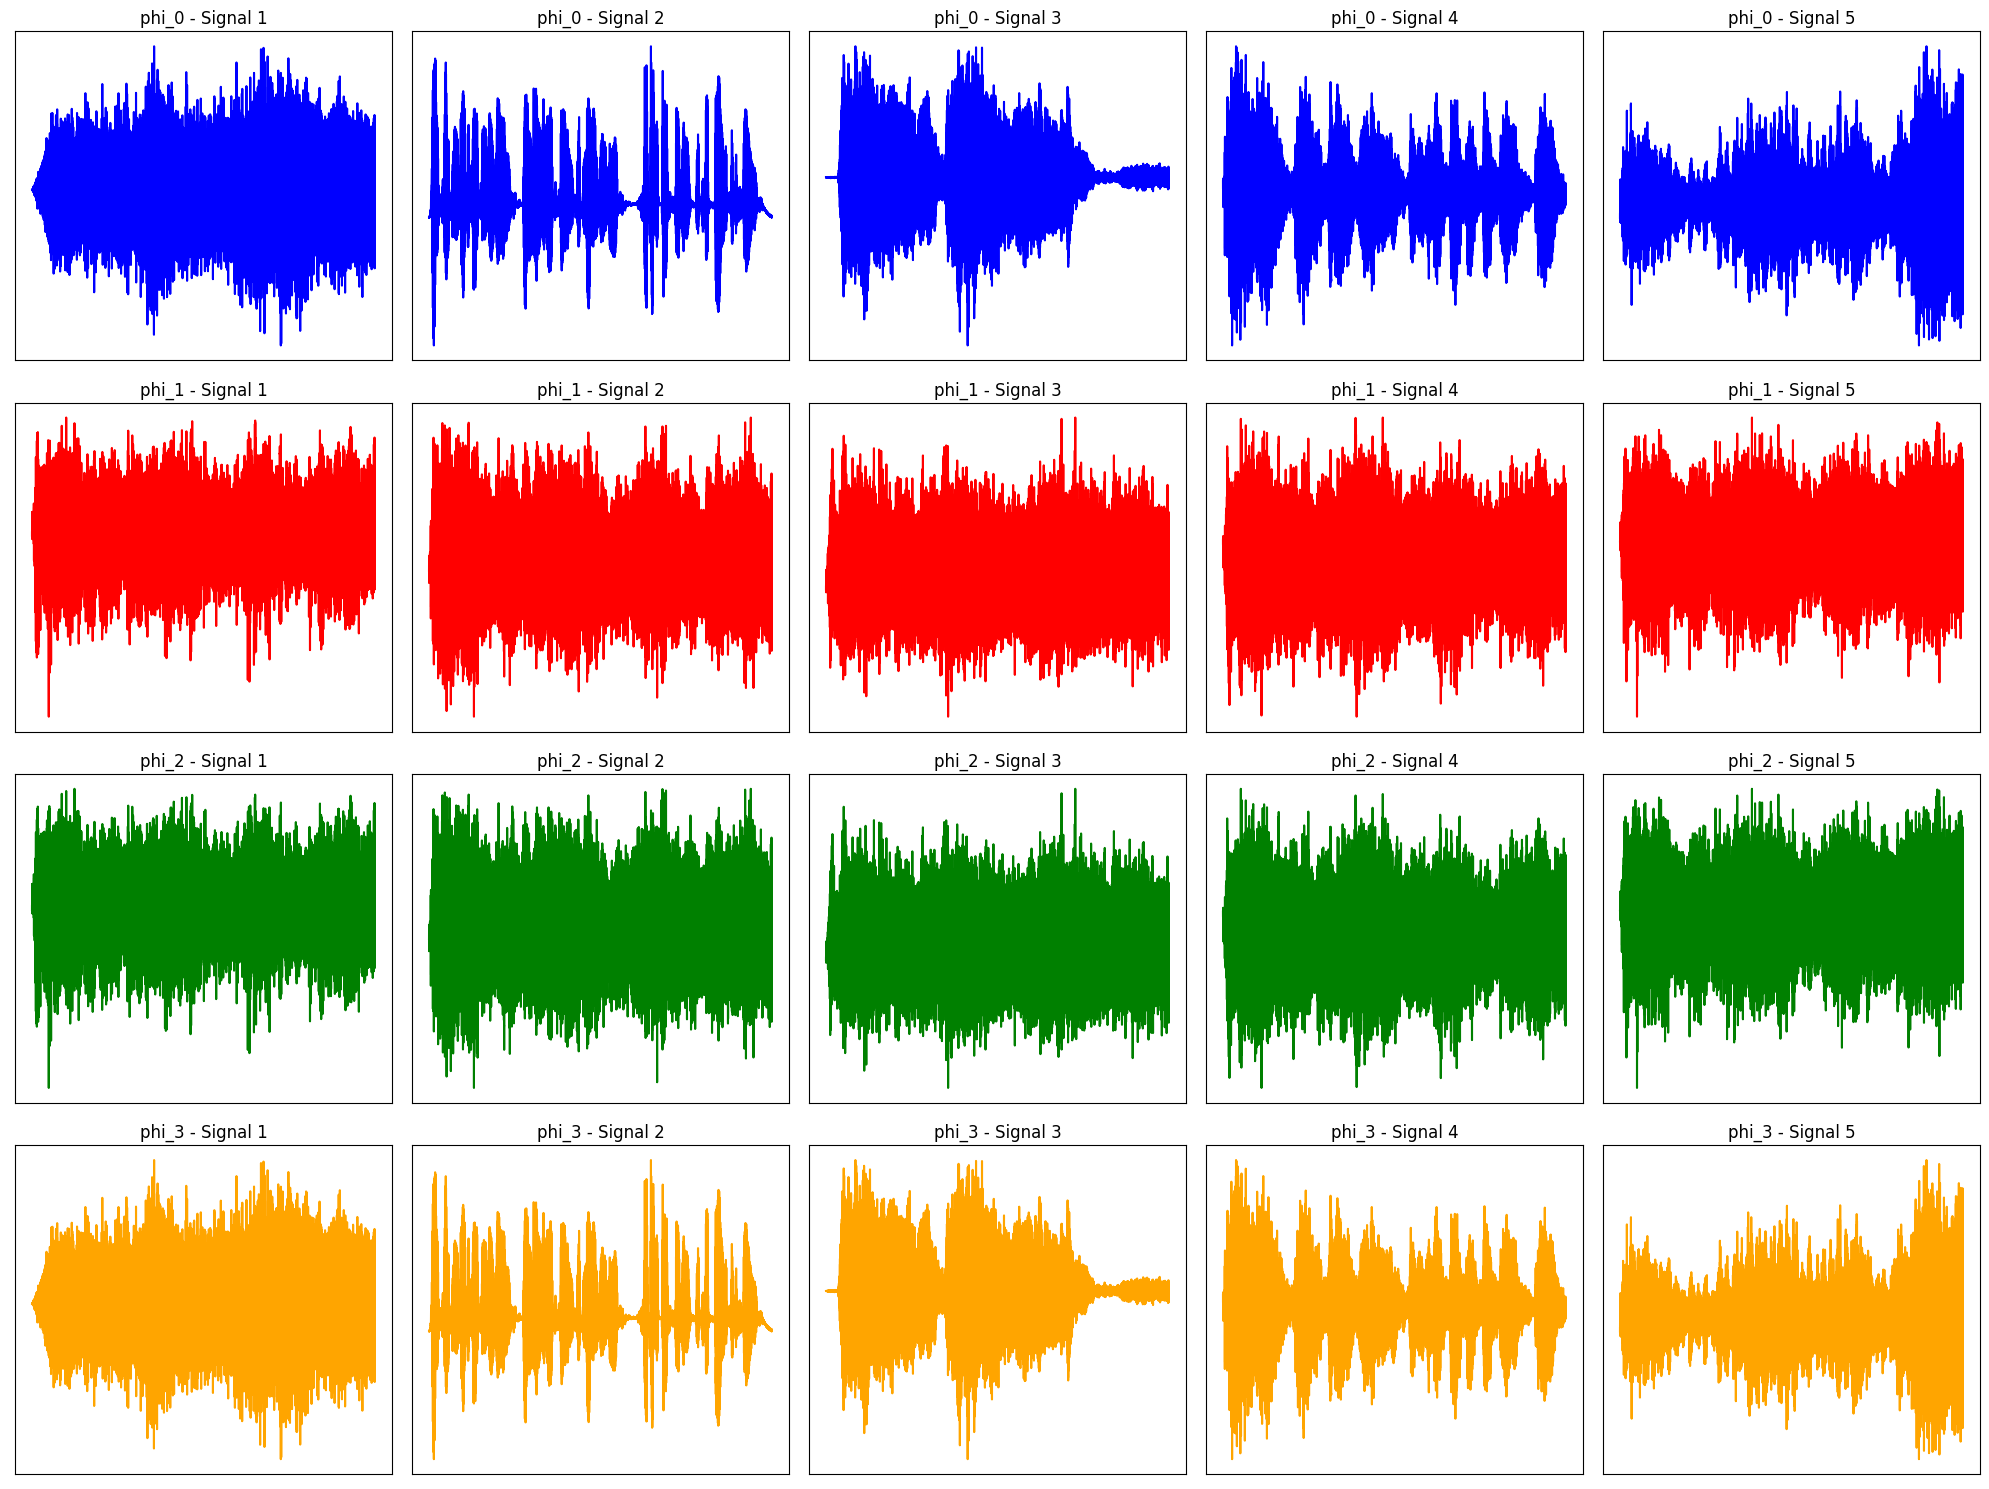

Successfully converged after 673 steps!
Successfully converged after 8040 steps!
Successfully converged after 4560 steps!
Successfully converged after 723 steps!
Reconstructed signals using orthogonal initialization


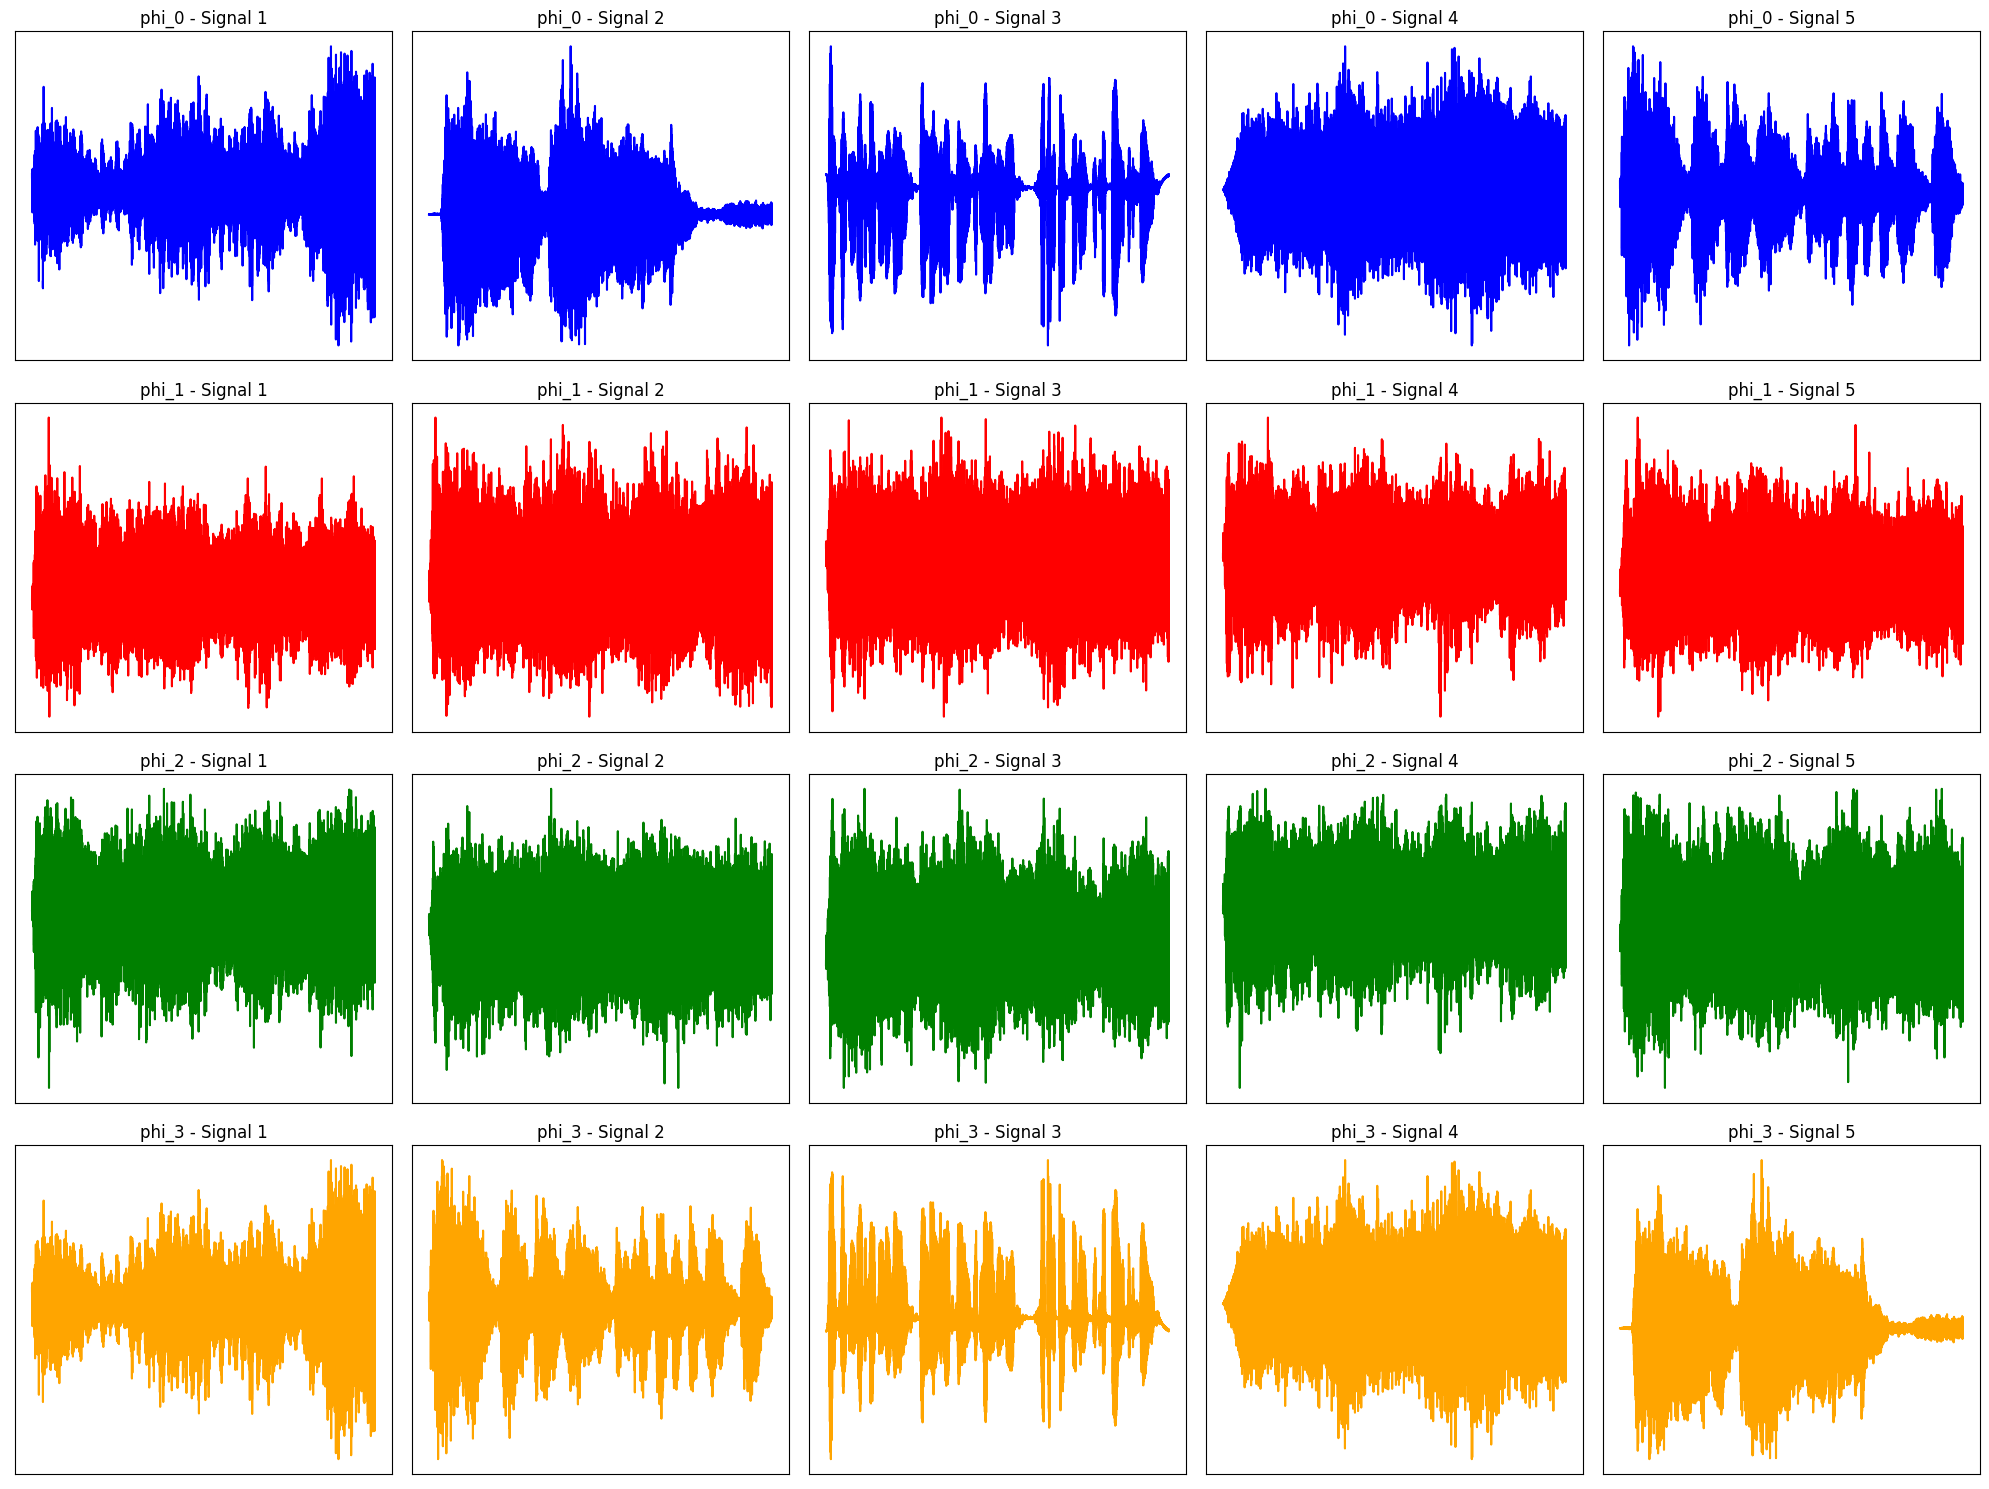

Successfully converged after 707 steps!
Successfully converged after 4419 steps!
Successfully converged after 2183 steps!
Successfully converged after 687 steps!
Reconstructed signals using xavier initialization


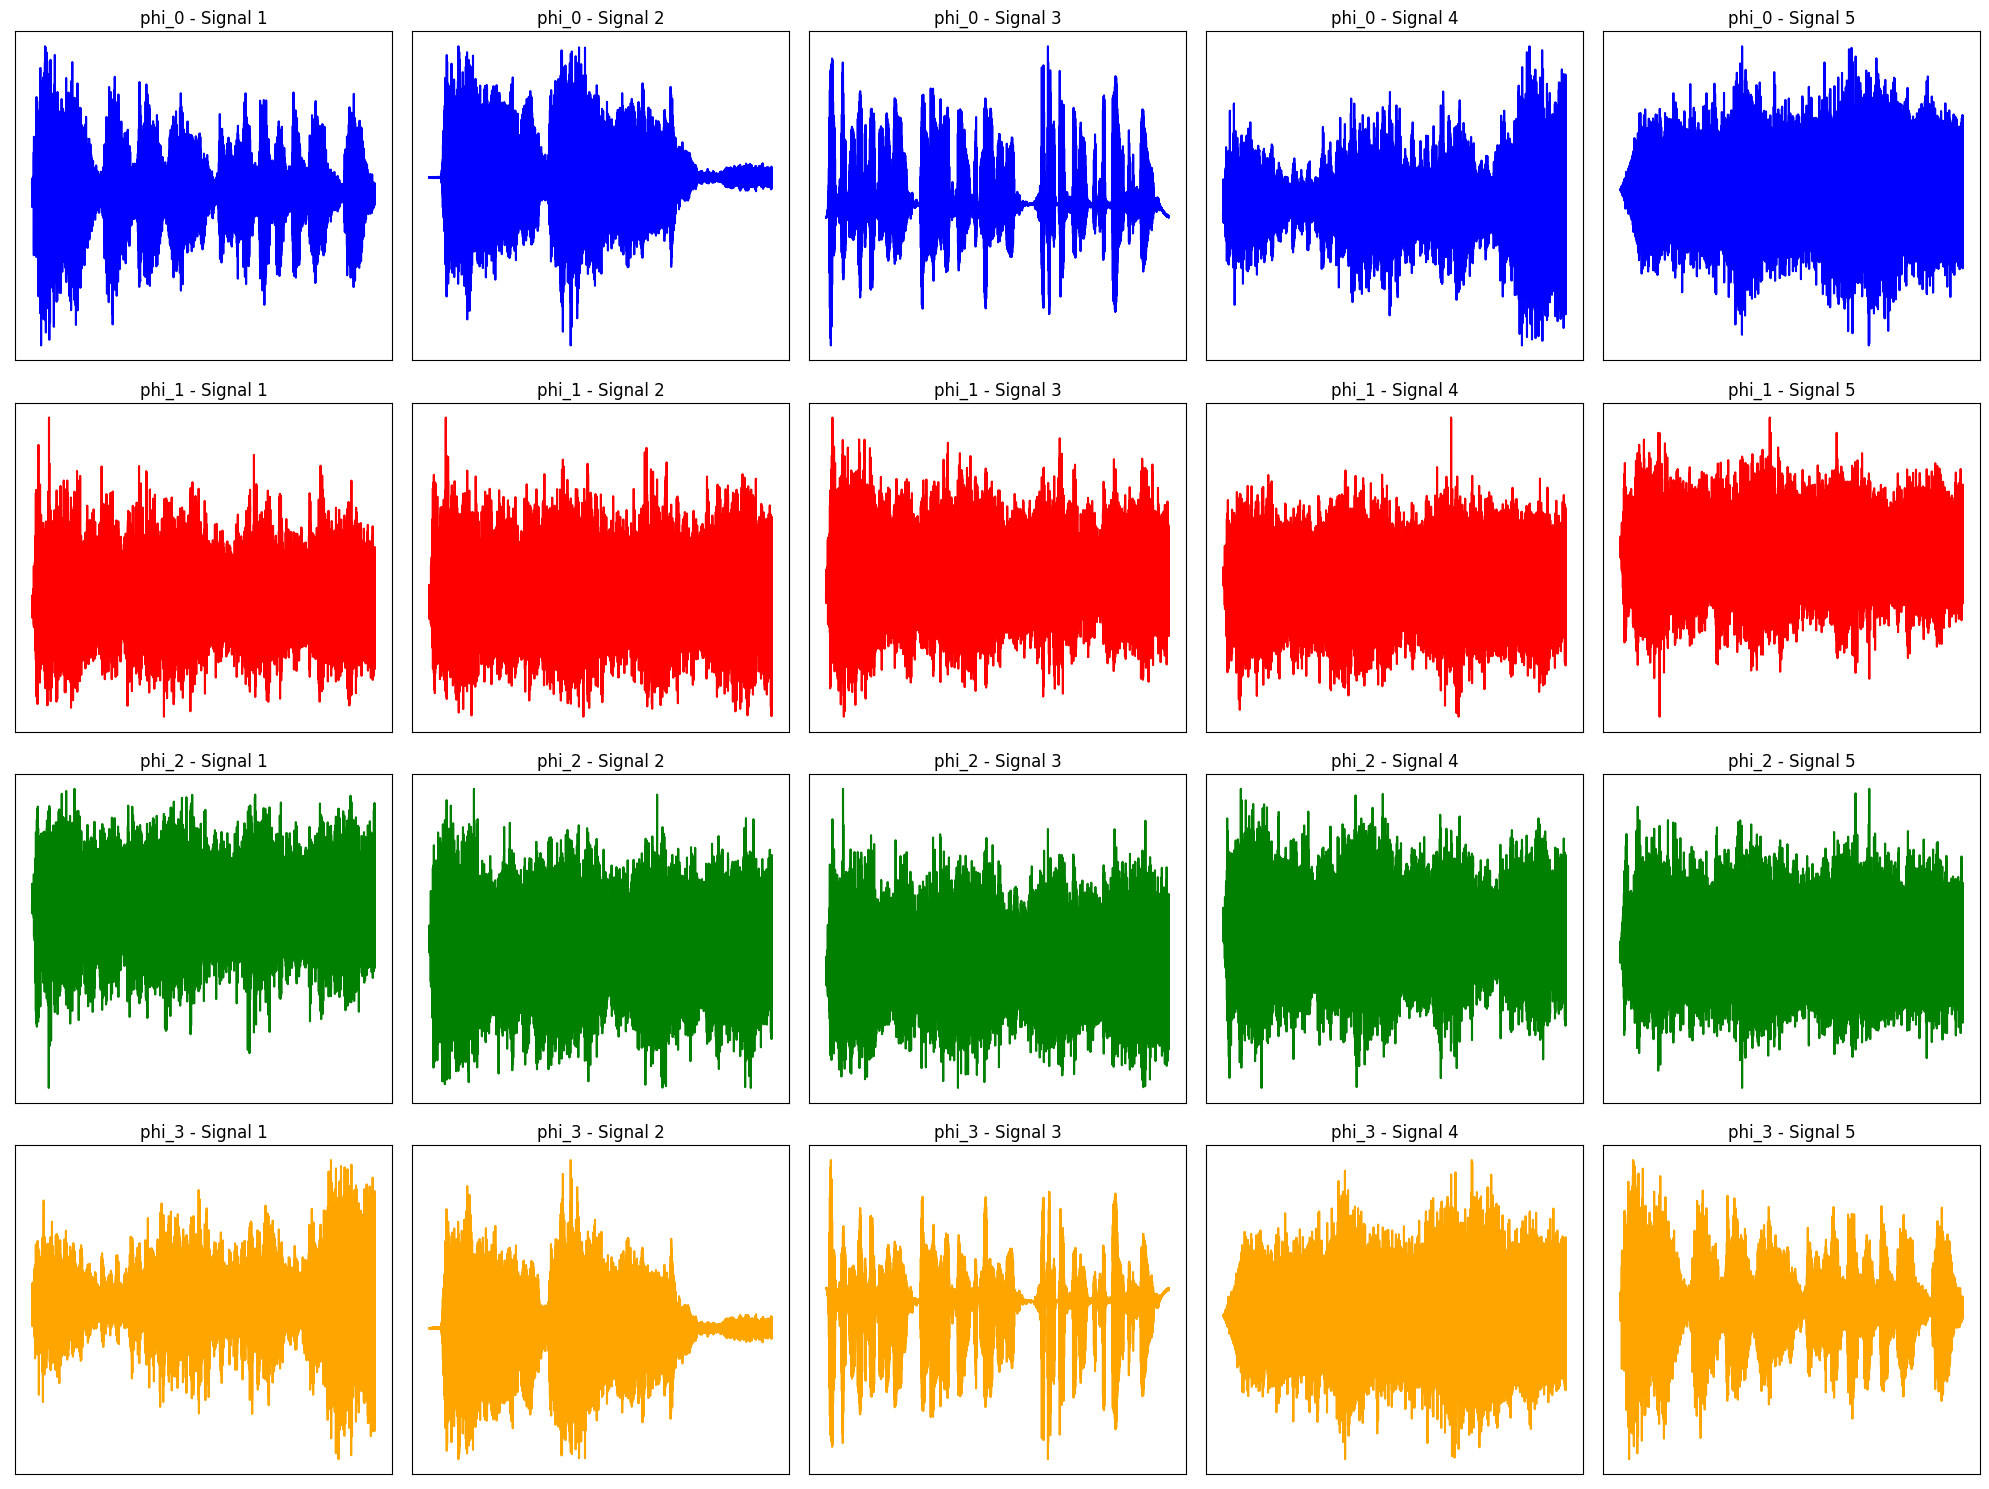

Successfully converged after 675 steps!
Successfully converged after 6743 steps!
Successfully converged after 3620 steps!
Successfully converged after 651 steps!
Reconstructed signals using nonsingular initialization


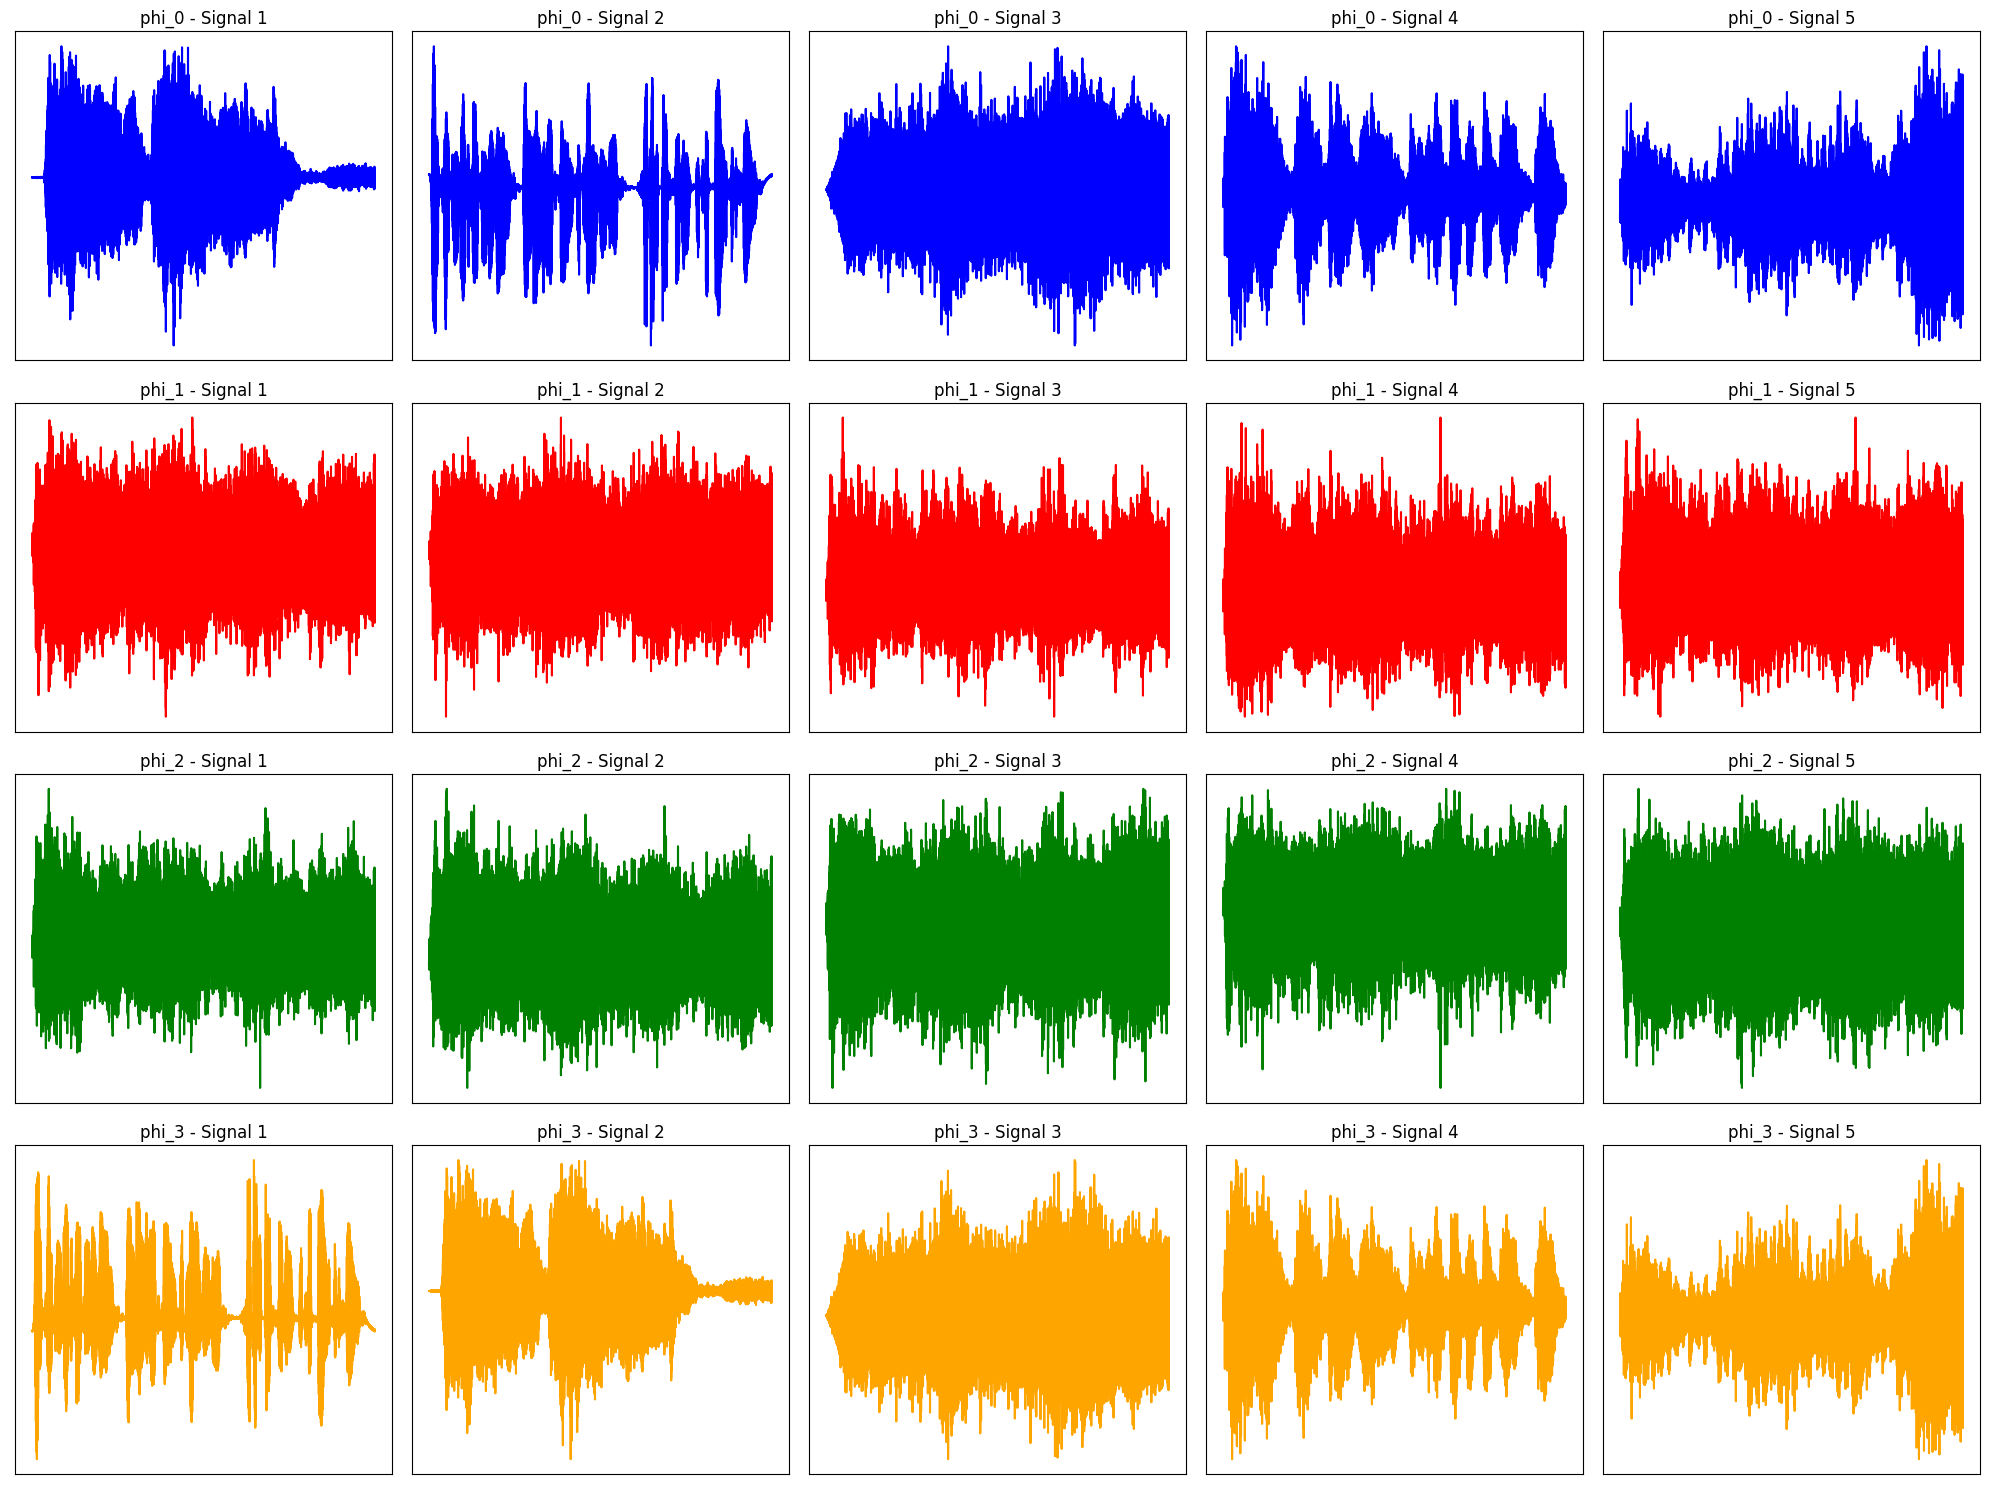

In [33]:
### 1.9 Audio demixing
# YOUR CODE HERE
# Mix the audio sources
A_audio = random_nonsingular_matrix(d=S_audio.shape[0])
X_audio = make_mixtures(S_audio, A_audio)

# Plot histograms of the mixed audio
plot_histograms(X_audio, source_files)

# Whitening the audio data
Xw_audio = whiten(X_audio)

# Perform ICA on the audio data
w_init_names = ['eye', 'orthogonal', 'xavier', 'nonsingular']
for w_init_n in w_init_names:
    W_estimates_audio = [ICA(Xw_audio, activation_function=phi, w_init_name=w_init_n) for phi in activation_functions]

    # Plot the reconstructed signals
    print(f"Reconstructed signals using {w_init_n} initialization")
    plot_reconstructed_signals(Xw_audio, W_estimates_audio)

Report your results. Using which activation functions can ICA recover the sources? Return a list of integers corresponding to successful activation functions. For example: ```[0, 1, 2, 3]``` if all activations are successful. 

## Answer

We can see observe only $\phi_0$ and $\phi_3$ fully recover the sources. $\phi_1$ and $\phi_2$ fail to do so and leave the signals mixed and unrecovered.

In [34]:
# YOUR CODE HERE
successful_activations = [0, 3]

In [35]:
for winner in successful_activations:
    assert type(winner) == int

### 1.10 Excess Kurtosis (15 points)
The (excess) kurtosis is a measure of 'peakedness' of a distribution. It is defined as
$$
\verb+Kurt+[X] = \frac{\mu_4}{\sigma^4} - 3 = \frac{\operatorname{E}[(X-{\mu})^4]}{(\operatorname{E}[(X-{\mu})^2])^2} - 3
$$
Here, $\mu_4$ is known as the fourth moment about the mean, and $\sigma$ is the standard deviation.
The '-3' term is introduced so that a Gaussian random variable has 0 excess kurtosis.
We will now try to understand the performance of the various activation functions by considering the kurtosis of the corresponding priors, and comparing those to the empirical kurtosis of our data.

#### 1.10.1 (10 points)
First, compute analytically the kurtosis of the four priors that you derived from the activation functions before. You may find it helpful to use an online service such as [Wolfram Alpha](https://www.wolframalpha.com/) or [Integral Calculator](https://www.integral-calculator.com/) to (help you) evaluate the required integrals. Give your answer as both an exact expression as well as a numerical approximation (for example $\frac{\pi}{2} \approx 1.571$).

## Answer

The general formula for calculating Kurtosis is given by:

$$
Kurt[X] = \frac{\operatorname{E}[(X-{\mu})^4]}{(\operatorname{E}[(X-{\mu})^2])^2} - 3
$$

To calculate the mean and the standard deviation, first we need to compute normalizing constants for each prior distribution. The normalizing constant is the integral of the prior distribution over all values of $a$:

$$
norm_0 = \int_{-\infty}^{\infty}p_0(a)da = \int_{-\infty}^{\infty} \frac{1}{\cosh(a)} da = \pi \approx 3.14159\\
norm_1 = \int_{-\infty}^{\infty}p_1(a)da = \int_{-\infty}^{\infty} \frac{\cosh(a)}{exp({a^2/2})} da = \sqrt{2 e \pi} \approx 4.13273 \\
norm_2 = \int_{-\infty}^{\infty}p_2(a)da = \int_{-\infty}^{\infty} \exp(-\frac{1}{4}a^4) da = \frac{\Gamma\left(\frac{1}{4}\right)}{\sqrt{2}} \approx 2.56369\\
norm_3 = \int_{-\infty}^{\infty}p_3(a)da = \int_{-\infty}^{\infty} \frac{1}{(a^2 + 5)^3} da = \frac{3\pi}{8 \cdot 5^{\frac{5}{2}}} \approx 0.02107 \\
$$

After calculating the normalizing constants, we can calculate the mean and the standard deviation of each prior distribution:

1) **Activation function $\phi_0(a) = -\tanh(a)$**:

$$
mu_4^{(0)} = \mathbb{E}[(X - \mu)^4] = \frac{1}{\text{norm}_0} \int_{-\infty}^{\infty} a^4 p_0(a) da = \frac{1}{ \pi} \int_{-\infty}^{\infty} a^4 \frac{1}{\cosh(a)} (a)  da = \frac{1}{\pi} \cdot \frac{5\pi^5}{16} \approx 6.08 \\

sigma^4_{0} = \mathbb{E}[(X - \mu)^2]^2 = \left(\frac{1}{\text{norm}_0} \int_{-\infty}^{\infty} a^2 p_0(a) da \right)^2 = \left(\frac{1}{\pi} \int_{-\infty}^{\infty} a^2 \frac{1}{\cosh(a)} (a)  da \right)^2 = \left(\frac{1}{\pi} \cdot \frac{\pi^3}{4} \right)^2 = \frac{\pi^4}{16} \approx 6.08807 \\ 
$$

Finally we can compute the kurtosis for $\phi_0$:

$$
Kurt[X] = \frac{\mu_4^{(0)}}{\sigma^4_{0}} - 3 = \frac{\frac{5\pi^4}{16}}{\frac{\pi^4}{16}} - 3 = 5 - 3 = 2
$$

We then repeat the same process for the other activation functions.

2) **Activation function $\phi_1(a) = -a + \tanh(a)$**:

$$
mu_4^{(1)} = \mathbb{E}[(X - \mu)^4] = \frac{1}{\text{norm}_1} \int_{-\infty}^{\infty} a^4 p_1(a) da = \frac{1}{\sqrt{2 e \pi}} \int_{-\infty}^{\infty} a^4 \frac{\cosh(a)}{exp({a^2/2})} da = \frac{1}{\sqrt{2 e \pi}} \cdot 5\cdot2^{\frac{3}{2}}\sqrt{e}\sqrt{\pi} = 10\\

sigma^4_{1} = \mathbb{E}[(X - \mu)^2]^2 = \left(\frac{1}{\text{norm}_1} \int_{-\infty}^{\infty} a^2 p_1(a) da \right)^2 = \left(\frac{1}{\sqrt{2 e \pi}} \int_{-\infty}^{\infty} a^2 \frac{\cosh(a)}{exp({a^2/2})} da \right)^2 = \left(\frac{1}{\sqrt{2 e \pi}} \cdot 2^{\frac{3}{2}} \sqrt{e \pi} \right)^2 = 4 \\
$$

$$
Kurt[X] = \frac{\mu_4^{(1)}}{\sigma^4_{1}} - 3 = \frac{10}{4} - 3 = -\frac{1}{2} \\
$$

3) **Activation function $\phi_2(a) = -a^3$**:

$$
\mu_4^{(2)} = \mathbb{E}[(X - \mu)^4] = \frac{1}{\text{norm}_2} \int_{-\infty}^{\infty} a^4 p_2(a) da = \frac{\sqrt{2}}{\Gamma\left(\frac{1}{4}\right)} \int_{-\infty}^{\infty} a^4 \exp(-\frac{1}{4}a^4) da = \frac{\sqrt{2}}{\Gamma\left(\frac{1}{4}\right)} \cdot \frac{\Gamma\left(\frac{1}{4}\right)}{\sqrt{2}} = 1 \\

sigma^4_{2} = \mathbb{E}[(X - \mu)^2]^2 = \left(\frac{1}{\text{norm}_2} \int_{-\infty}^{\infty} a^2 p_2(a) da \right)^2 = \left(\frac{\sqrt{2}}{\Gamma\left(\frac{1}{4}\right)} \int_{-\infty}^{\infty} a^2 \exp(-\frac{1}{4}a^4) da \right)^2 = \left(\frac{\sqrt{2}}{\Gamma\left(\frac{1}{4}\right)} \cdot \sqrt{2}\cdot \Gamma\left(\frac{3}{4}\right) \right)^2 = \frac{4\Gamma^2\left(\frac{3}{4}\right)}{\Gamma^2\left(\frac{1}{4}\right)} \approx 0.45695 \\
$$

$$
Kurt[X] = \frac{\mu_4^{(2)}}{\sigma^4_{2}} - 3 = \frac{1}{\frac{4\Gamma^2\left(\frac{3}{4}\right)}{\Gamma^2\left(\frac{1}{4}\right)}} - 3 \approx -0.81156 \\
$$

4) **Activation function $\phi_3(a) = -\frac{6a}{a^2 + 5}$**:

$$
\mu_4^{(3)} = \mathbb{E}[(X - \mu)^4] = \frac{1}{\text{norm}_3} \int_{-\infty}^{\infty} a^4 p_3(a) da = \frac{8 \cdot 5^{\frac{5}{2}}}{3\pi} \int_{-\infty}^{\infty} a^4 \frac{1}{(a^2 + 5)^3} da = \frac{8 \cdot 5^{\frac{5}{2}}}{3\pi} \cdot \frac{3\pi}{8\sqrt{5}} = 25 \\

\sigma^4_{3} = \mathbb{E}[(X - \mu)^2]^2 = \left(\frac{1}{\text{norm}_3} \int_{-\infty}^{\infty} a^2 p_3(a) da \right)^2 = \left(\frac{8 \cdot 5^{\frac{5}{2}}}{3\pi} \int_{-\infty}^{\infty} a^2 \frac{1}{(a^2 + 5)^3} da \right)^2 = \left(\frac{8 \cdot 5^{\frac{5}{2}}}{3\pi} \cdot \frac{\pi}{8\cdot 5^{\frac{3}{2}}} \right)^2 = \frac{25}{9} \approx 2.77777 \\
$$

$$
Kurt[X] = \frac{\mu_4^{(3)}}{\sigma^4_{3}} - 3 = \frac{25}{\frac{25}{9}} - 3 = 6 \\
$$

In [36]:
### Include your answer here (you can use math.gamma if needed)
def get_kurtosis():
    # Return a list with 4 numbers / expressions
    # return [0, 0, 0, 0]

    # YOUR CODE HERE
    k_3 = (1 / (4 * (math.gamma(3 / 4) ** 2 / math.gamma(1 / 4) ** 2))) - 3
    return [2, -0.5, k_3, 6]

In [37]:
# Let's check
kurtosis = get_kurtosis()
print(kurtosis)
assert len(kurtosis) == 4

[2, -0.5, -0.8115603847735238, 6]


#### 1.10.2 (5 points)
Now use the `scipy.stats.kurtosis` function, with the `fisher` option set to `True`, to compute the empirical kurtosis of the dummy signals and the real audio signals.

For both sets of signals and the activations, state whether they are leptokurtic, mesokurtic or platykurtic. Fill the three lists below with "lepto", "meso" or "platy". Can you explain the performance of each activation on the dummy signals and real audio using this data?

In [38]:
# YOUR CODE HERE
from scipy.stats import kurtosis


def assign_kurtosis_string(k: float) -> str:
    """
    Assign the kurtosis string based on the kurtosis value.
    
    Args:
        k (float): The kurtosis value 

    Returns:
        str: The kurtosis string
    """
    if k > 0:
        return "lepto"
    elif np.isclose(k, 0):
        return "meso"
    else:
        return "platy"


def compute_and_classify_kurtosis(signals: list) -> list:
    return [assign_kurtosis_string(kurtosis(signal, fisher=True)) for signal in signals]


dummy_signals = np.random.randn(5, 10_000)
dummy_kurtosis = compute_and_classify_kurtosis(dummy_signals)
audio_kurtosis = compute_and_classify_kurtosis(S_audio)

dummy_values_for_activations = np.random.randn(4, 10_000)
activation_values = [phi(dummy_values_for_activations[i]) for i, phi in enumerate(activation_functions)]
activation_kurtosis = compute_and_classify_kurtosis(activation_values)

In [39]:
assert len(dummy_kurtosis) == 5
assert len(audio_kurtosis) == 5
assert len(activation_kurtosis) == 4

legal_values = set(['lepto', 'meso', 'platy'])
assert len(set(dummy_kurtosis) - legal_values) == 0
assert len(set(audio_kurtosis) - legal_values) == 0
assert len(set(activation_kurtosis) - legal_values) == 0

In [40]:
print('Dummy kurtosis:', dummy_kurtosis)
print('Audio kurtosis:', audio_kurtosis)
print('Activation kurtosis:', activation_kurtosis)

Dummy kurtosis: ['lepto', 'lepto', 'platy', 'platy', 'platy']
Audio kurtosis: ['lepto', 'lepto', 'lepto', 'lepto', 'lepto']
Activation kurtosis: ['platy', 'lepto', 'lepto', 'platy']


## Answer

We can see difference in results for the dummy signals and the real audio signals. 

For the real audio signals, results are only `lepto` which means that the signals are leptokurtic. This means that the tails of the distribution are heavier than the normal distribution. This is expected as the audio signals are real-world signals and are not normally distributed. For the dummy values there are `lepto` as well as `platy` kurtosis values. This means that the dummy signals exhibit both `leptokurtic` (heavy tails) and `platykurtic` (light tails) behaviors. The presence of `platykurtic` values for the dummy signals indicates that these signals don't follow a consistent real-world pattern like the audio signals, which may explain the different kurtosis characteristics.

For the activation functions and its dummy values for testing we can observe also the mix of `lepto` and `platy` values. This is expected as the activation functions are designed to be non-linear and are not normally distributed. The dummy signals are generated using normal distribution and the activation functions are not able to capture the dummy signals well.